In [ ]:
# 폰트 추가로 그래프를 그렸을때 잘 나올 수 있도록 설정해주기

%matplotlib inline

import matplotlib as mpl  # 기본 설정
import matplotlib.pyplot as plt  # 그래프 그리기
import matplotlib.font_manager as fm  # 폰트 관리|


!apt-get update -qq         # apt-get 패키지 설치 명령어, -qq : 에러외 메세지 숨기기
!apt-get install fonts-nanum* -qq #나눔글꼴 설치

fe = fm.FontEntry(fname=r'/usr/share/fonts/truetype/nanum/NanumGothic.ttf', name='NanumGothic') #파일 저장되어있는 경로와 이름 설정
fm.fontManager.ttflist.insert(0, fe)  # Matplotlib에 폰트 추가
plt.rcParams.update({'font.size': 10, 'font.family': 'NanumGothic'}) #폰트설정


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.font_manager as fm
import datetime as dt
import seaborn as sns
import numpy as np
import math
import warnings
import calendar

from mlxtend.frequent_patterns import association_rules, apriori
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from yellowbrick.cluster.elbow import kelbow_visualizer
from yellowbrick.cluster import silhouette_visualizer
from sklearn.preprocessing import RobustScaler

from lightgbm import LGBMClassifier


warnings.filterwarnings("ignore")


/usr/local/lib/python3.10/dist-packages/yellowbrick/style/colors.py:35: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  mpl_ge_150 = LooseVersion(mpl.__version__) >= "1.5.0"
/usr/local/lib/python3.10/dist-packages/setuptools/_distutils/version.py:345: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/usr/local/lib/python3.10/dist-packages/yellowbrick/style/rcmod.py:31: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  mpl_ge_150 = LooseVersion(mpl.__version__) >= "1.5.0"
/usr/local/lib/python3.10/dist-packages/setuptools/_distutils/version.py:345: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


데이터 불러오기

In [ ]:
df_on = pd.read_csv('Onlinesales_info.csv')
df_cus = pd.read_csv('Customer_info.csv')
df_dis = pd.read_csv('Discount_info.csv')
df_mar = pd.read_csv('Marketing_info.csv')
df_tax = pd.read_csv('Tax_info.csv')

같은 거래 아이디인 경우 확인

In [ ]:
# 오차 범위 설정
epsilon = 1e-10

# 배송료를 그룹화한 후, 첫 번째 값과 평균값이 거의 같은지 비교
delivery_compare = np.isclose(df_on.groupby("거래ID")["배송료"].first(), df_on.groupby("거래ID")["배송료"].mean(), atol=epsilon)

if False in delivery_compare:
  print("거래아이디가 같아도 배송료가 다른 경우가 있습니다.")
else:
  print("거래아이디가 같은 경우 배송료가 다 같습니다.")

거래아이디가 같은 경우 배송료가 다 같습니다.


In [ ]:
# 같은 거래ID를 가진 경우에는 배송료를 거래총량으로 나눠준다.
replacement_values = round(df_on.groupby("거래ID")["배송료"].first() / df_on.groupby("거래ID")["배송료"].count(),2)
df_on["배송료"] = df_on["거래ID"].map(replacement_values)

- 같은 거래 ID를 가진 거래가 많고, 배송료가 동일 -> 배송료를 아끼기 위해 한번에 구매한 사례라고 판단

데이터분석을 위한 속성 생성 및 merge

In [ ]:
df_dis['거래월'] = df_dis['월'].map({'Jan':1, 'Feb':2, 'Mar':3, 'Apr':4, 'May':5, 'Jun':6,'Jul':7, 'Aug':8, 'Sep':9, 'Oct':10, 'Nov':11, 'Dec':12})
df_dis = df_dis.drop(columns = '월')

# 고객정보와 제품당 세금정보를 판매정보에 결합
dat_raw = df_on.merge(df_cus, how='left', on = ['고객ID'])
dat_raw = dat_raw.merge(df_tax, how='left', on = ['제품카테고리'])

# 할인정보를 판매정보에 결합
dat_raw['거래월'] = dat_raw['거래날짜'].apply(lambda x: x[5:7]).astype(int)
dat_raw = dat_raw.merge(df_dis, how = 'left', on = ['제품카테고리','거래월'])

# 거래날짜를 datetime으로 변경
dat_raw['거래날짜'] = pd.to_datetime(dat_raw['거래날짜'])
dat_raw["요일"] = dat_raw["거래날짜"].dt.weekday
dat_raw["요일"] = dat_raw["요일"].apply(lambda x: calendar.day_name[x])

# 쿠폰상태가 used인 데이터를 할인정책에 맞게 추가해서, 할인율과 할인금액 항목 생성
dat_raw = dat_raw.drop(columns = '쿠폰코드')
dat_raw.loc[~(dat_raw['쿠폰상태'] == 'Used'),'할인율'] = 0
dat_raw['할인율'] = dat_raw['할인율'].fillna(0)
dat_raw['할인금액'] = (dat_raw['수량']*dat_raw['평균금액']*(1+dat_raw['GST']))*(dat_raw['할인율']/100)

# 총 거래금액 = (수량 * 평균금액 * (1-할인율/100) * (1+GST)) + 배송료
dat_raw['거래금액'] = (dat_raw['수량']*dat_raw['평균금액']*(1-dat_raw['할인율']/100)*(1+dat_raw['GST'])) + dat_raw['배송료']

print(dat_raw.shape)
dat_raw.head()

(52924, 18)


,고객ID,거래ID,거래날짜,제품ID,제품카테고리,수량,평균금액,배송료,쿠폰상태,성별,고객지역,가입기간,GST,거래월,할인율,요일,할인금액,거래금액
0,USER_1358,Transaction_0000,2019-01-01,Product_0981,Nest-USA,1,153.71,6.50,Used,남,Chicago,12,0.10,1,10.0,Tuesday,16.9081,158.6729
1,USER_1358,Transaction_0001,2019-01-01,Product_0981,Nest-USA,1,153.71,6.50,Used,남,Chicago,12,0.10,1,10.0,Tuesday,16.9081,158.6729
2,USER_1358,Transaction_0002,2019-01-01,Product_0904,Office,1,2.05,6.50,Used,남,Chicago,12,0.10,1,10.0,Tuesday,0.2255,8.5295
3,USER_1358,Transaction_0003,2019-01-01,Product_0203,Apparel,5,17.53,0.06,Not Used,남,Chicago,12,0.18,1,0.0,Tuesday,0.0000,103.4870
4,USER_1358,Transaction_0003,2019-01-01,Product_0848,Bags,1,16.50,0.06,Used,남,Chicago,12,0.18,1,10.0,Tuesday,1.9470,17.5830


In [ ]:
# 계절 속성 추가
def get_season(month):
    if month in [3, 4, 5]:
       return '봄'
    elif month in [6, 7, 8]:
        return '여름'
    elif month in [9, 10, 11]:
        return '가을'
    else:  # 12, 1, 2
        return '겨울'

dat_raw['계절'] = dat_raw['거래월'].apply(get_season)

In [ ]:
min_month = dat_raw.groupby("고객ID", as_index=False)["거래월"].min()
min_month.rename({"거래월" : "최소거래월"}, axis=1, inplace=True)

max_month = dat_raw.groupby("고객ID", as_index=False)["거래월"].max()
max_month.rename({"거래월" : "최대거래월"}, axis=1, inplace=True)

In [ ]:
# 최소거래월과 최대거래월 추가
dat_raw = dat_raw.merge(min_month, on="고객ID", how="left")
dat_raw = dat_raw.merge(max_month, on="고객ID", how="left")
dat_raw["고객수명"] = (dat_raw["최대거래월"] - dat_raw["최소거래월"]) + 1
dat_raw.head()

,고객ID,거래ID,거래날짜,제품ID,제품카테고리,수량,평균금액,배송료,쿠폰상태,성별,...,GST,거래월,할인율,요일,할인금액,거래금액,계절,최소거래월,최대거래월,고객수명
0,USER_1358,Transaction_0000,2019-01-01,Product_0981,Nest-USA,1,153.71,6.50,Used,남,...,0.10,1,10.0,Tuesday,16.9081,158.6729,겨울,1,1,1
1,USER_1358,Transaction_0001,2019-01-01,Product_0981,Nest-USA,1,153.71,6.50,Used,남,...,0.10,1,10.0,Tuesday,16.9081,158.6729,겨울,1,1,1
2,USER_1358,Transaction_0002,2019-01-01,Product_0904,Office,1,2.05,6.50,Used,남,...,0.10,1,10.0,Tuesday,0.2255,8.5295,겨울,1,1,1
3,USER_1358,Transaction_0003,2019-01-01,Product_0203,Apparel,5,17.53,0.06,Not Used,남,...,0.18,1,0.0,Tuesday,0.0000,103.4870,겨울,1,1,1
4,USER_1358,Transaction_0003,2019-01-01,Product_0848,Bags,1,16.50,0.06,Used,남,...,0.18,1,10.0,Tuesday,1.9470,17.5830,겨울,1,1,1


In [ ]:
df_mar["거래날짜"] = pd.to_datetime(df_mar['날짜'])
df_mar.drop(["날짜"], axis=1, inplace=True)
df_mar

,오프라인비용,온라인비용,거래날짜
0,4500,2424.50,2019-01-01
1,4500,3480.36,2019-01-02
2,4500,1576.38,2019-01-03
3,4500,2928.55,2019-01-04
4,4500,4055.30,2019-01-05
...,...,...,...
360,4000,3396.87,2019-12-27
361,4000,3246.84,2019-12-28
362,4000,2546.58,2019-12-29
363,4000,674.31,2019-12-30


In [ ]:
dat_raw = dat_raw.merge(df_mar, on="거래날짜", how="left")
dat_raw.head()

,고객ID,거래ID,거래날짜,제품ID,제품카테고리,수량,평균금액,배송료,쿠폰상태,성별,...,할인율,요일,할인금액,거래금액,계절,최소거래월,최대거래월,고객수명,오프라인비용,온라인비용
0,USER_1358,Transaction_0000,2019-01-01,Product_0981,Nest-USA,1,153.71,6.50,Used,남,...,10.0,Tuesday,16.9081,158.6729,겨울,1,1,1,4500,2424.5
1,USER_1358,Transaction_0001,2019-01-01,Product_0981,Nest-USA,1,153.71,6.50,Used,남,...,10.0,Tuesday,16.9081,158.6729,겨울,1,1,1,4500,2424.5
2,USER_1358,Transaction_0002,2019-01-01,Product_0904,Office,1,2.05,6.50,Used,남,...,10.0,Tuesday,0.2255,8.5295,겨울,1,1,1,4500,2424.5
3,USER_1358,Transaction_0003,2019-01-01,Product_0203,Apparel,5,17.53,0.06,Not Used,남,...,0.0,Tuesday,0.0000,103.4870,겨울,1,1,1,4500,2424.5
4,USER_1358,Transaction_0003,2019-01-01,Product_0848,Bags,1,16.50,0.06,Used,남,...,10.0,Tuesday,1.9470,17.5830,겨울,1,1,1,4500,2424.5


데이터 분석 지표 CLV(고객생명주기), retention, apriori(연관검색) 구현

In [ ]:
def clv(df):
  average_purchase = df["거래금액"].sum() / df["거래ID"].count()
  average_frequency = df["거래ID"].count() / df["고객ID"].nunique()
  average_customer_life = df["고객수명"].mean()

  customer_value = average_purchase * average_frequency
  clv = customer_value * average_customer_life
  return round(clv,2)

In [ ]:
def plot_retention(df):

  # 월단위 리텐션
  dat_retention = df.groupby(['최소거래월','거래월'],as_index=False).agg({'고객ID': "nunique"})
  dat_retention['경과월'] = dat_retention['거래월']-dat_retention['최소거래월']

  first_month_users = dat_retention.groupby('최소거래월')['고객ID'].first()
  dat_retention = dat_retention.pivot_table('고객ID','최소거래월','경과월')
  dat_retention = dat_retention.T.divide(first_month_users.to_list()).T.fillna(0)

  mask = np.array(list(map(lambda x: list(np.flip(x)), np.tril(np.ones_like(dat_retention, dtype=bool), k=-1))))

  return sns.heatmap(dat_retention
                       ,mask = mask
                       ,annot=True, fmt='.0%', cmap = 'YlGn')

In [ ]:
# 고객에 대한 연관검색(카테고리)
def category_cross_selling_user(df):
    dat_association = df.groupby(['고객ID', '제품카테고리'])['수량'].sum().unstack().fillna(0)
    dat_association[dat_association > 0] = 1

    # 지지도 계산
    frequent_itemsets = apriori(dat_association, min_support=0.2, use_colnames=True)
    association_rules_df = association_rules(frequent_itemsets, metric='lift', min_threshold=1.0)

    return association_rules_df.sort_values(['lift', 'support'], ascending=[False, False])[["antecedents", "consequents", "support", "confidence",
                                                                       "leverage", "conviction", "zhangs_metric", "lift"]]
# 고객에 대한 연관검색(유저)
def product_cross_selling_user(df):
    dat_association = df.groupby(['고객ID', '제품ID'])['수량'].sum().unstack().fillna(0)
    dat_association[dat_association > 0] = 1

    # 지지도 계산
    frequent_itemsets = apriori(dat_association, min_support=0.2, use_colnames=True)
    association_rules_df = association_rules(frequent_itemsets, metric='lift', min_threshold=1.0)

    return association_rules_df.sort_values(['lift', 'support'], ascending=[False, False])[["antecedents", "consequents", "support", "confidence",
                                                                       "leverage", "conviction", "zhangs_metric", "lift"]]
# 거래에 대한 연관검색(카테고리)
def category_cross_selling_transaction(df):
    dat_association = df.groupby(['거래ID', '제품카테고리'])['수량'].sum().unstack().fillna(0)
    dat_association[dat_association > 0] = 1

    # 지지도 계산
    frequent_itemsets = apriori(dat_association, min_support=0.01, use_colnames=True)
    association_rules_df = association_rules(frequent_itemsets, metric='lift', min_threshold=1.3)

    return association_rules_df.sort_values(['lift', 'support'], ascending=[False, False])[["antecedents", "consequents", "support", "confidence",
                                                                       "leverage", "conviction", "zhangs_metric", "lift"]]

In [ ]:
# def arppu(df):
#   # 월단위 arppu
#   dat_arppu = df.groupby(['거래월'],as_index=False).agg({"고객ID": "nunique", "거래금액":"sum"})
#   dat_arppu['arppu'] = dat_arppu["거래금액"] / dat_arppu["고객ID"]

#   return dat_arppu[["거래월","arppu"]]

# def cac(df):
#   # 월단위 cac
#   dat_cac = df.groupby(['최소거래월'],as_index=False).agg({"고객ID":"nunique", "오프라인비용": "sum", "온라인비용":"sum"})
#   dat_cac['총마케팅비용'] = dat_cac["오프라인비용"] + dat_cac["온라인비용"]
#   dat_cac['cac'] = dat_cac["총마케팅비용"] / dat_cac["고객ID"]

#   return dat_cac

#RFM

In [ ]:
dat_raw.head()

,고객ID,거래ID,거래날짜,제품ID,제품카테고리,수량,평균금액,배송료,쿠폰상태,성별,...,할인율,요일,할인금액,거래금액,계절,최소거래월,최대거래월,고객수명,오프라인비용,온라인비용
0,USER_1358,Transaction_0000,2019-01-01,Product_0981,Nest-USA,1,153.71,6.50,Used,남,...,10.0,Tuesday,16.9081,158.6729,겨울,1,1,1,4500,2424.5
1,USER_1358,Transaction_0001,2019-01-01,Product_0981,Nest-USA,1,153.71,6.50,Used,남,...,10.0,Tuesday,16.9081,158.6729,겨울,1,1,1,4500,2424.5
2,USER_1358,Transaction_0002,2019-01-01,Product_0904,Office,1,2.05,6.50,Used,남,...,10.0,Tuesday,0.2255,8.5295,겨울,1,1,1,4500,2424.5
3,USER_1358,Transaction_0003,2019-01-01,Product_0203,Apparel,5,17.53,0.06,Not Used,남,...,0.0,Tuesday,0.0000,103.4870,겨울,1,1,1,4500,2424.5
4,USER_1358,Transaction_0003,2019-01-01,Product_0848,Bags,1,16.50,0.06,Used,남,...,10.0,Tuesday,1.9470,17.5830,겨울,1,1,1,4500,2424.5


In [ ]:
# R,F,M 변수 정의
today = pd.to_datetime('2020-01-01') # 19년도 데이터이므로 2020-01-01을 최근 날짜로 정의
segment = dat_raw.groupby('고객ID').agg({'거래날짜' : lambda x: (today - x.max()).days, # Recency = 최근거래 이후 경과일
                                    '거래ID' : 'count', # Frequency = 19년도 1년간 거래횟수
                                    '거래금액' : 'sum'}) # Monetary = 19년도 1년간 거래금액 총합

segment.columns = ['R_경과일','F_거래횟수','M_총거래금액']
segment.head()

,R_경과일,F_거래횟수,M_총거래금액
고객ID,,,
USER_0000,108,2,26.84174
USER_0001,60,60,15204.23396
USER_0002,74,23,1534.63594
USER_0003,18,17,1397.71528
USER_0004,108,36,1437.83900


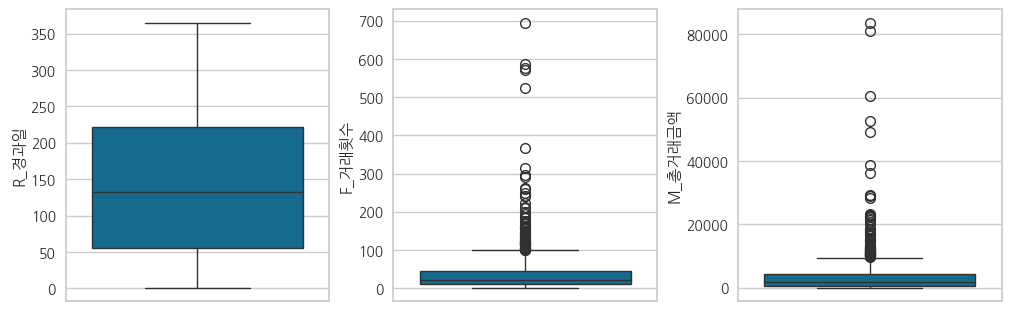

In [ ]:
fig,ax = plt.subplots(1,3, figsize = (10,3), constrained_layout = True)
for i,c in enumerate(list(segment.columns)):
    sns.boxplot(y = segment[c], ax = ax[i])
plt.show()

- R_경과일에 비해, F_거래횟수와 M_총거래금액은 이상치가 많이 확인되었다.

In [ ]:
segment.describe()

,R_경과일,F_거래횟수,M_총거래금액
count,1468.000000,1468.000000,1468.000000
mean,145.292234,36.051771,3398.969923
std,101.936959,50.885680,5440.450649
min,1.000000,1.000000,1.390000
25%,56.000000,10.000000,699.640800
50%,132.000000,21.000000,1861.248440
75%,221.000000,46.000000,4192.818965
max,365.000000,695.000000,83634.543440


In [ ]:
def calculatet_outlier(df,column):
    iqr = df[column].quantile(0.75) - df[column].quantile(0.25)
    out = df[column].quantile(0.75) + iqr*1.5
    return out

In [ ]:
# R,F,M 구간정의
segment['R'] = pd.qcut(segment['R_경과일'], q = [0, 0.2,0.4, 0.6, 0.8, 1],
                              labels=[5,4,3,2,1]).astype(int)
segment['F'] = pd.cut(segment['F_거래횟수'], bins = [0, 10, 21, 46, calculatet_outlier(segment,'F_거래횟수'), max(segment['F_거래횟수'])],
                              labels=[1,2,3,4,5]).astype(int)
segment['M'] = pd.cut(segment['M_총거래금액'], bins = [0, 707, 1888, 4250, calculatet_outlier(segment,'M_총거래금액'), max(segment['M_총거래금액'])],
                              labels=[1,2,3,4,5]).astype(int)
segment.head()

,R_경과일,F_거래횟수,M_총거래금액,R,F,M
고객ID,,,,,,
USER_0000,108,2,26.84174,3,1,1
USER_0001,60,60,15204.23396,4,4,5
USER_0002,74,23,1534.63594,4,3,2
USER_0003,18,17,1397.71528,5,2,2
USER_0004,108,36,1437.83900,3,3,2


- 이상치가 없는 R값 : 5분위로 나누어서 점수배분
- 이상치가 존재하는 F,M값 : 0 ~ Q1, Q1 ~ Q2, Q2 ~ Q3, Q3 ~ upper_quartile, upper_quartile ~ max 값으로 범위를 나누어서 점수 배분   


In [ ]:
features = segment[['R_경과일', 'F_거래횟수', 'M_총거래금액']]

sc= RobustScaler() # F와 M변수에 이상치 다수 존재하기에 이상치에 덜 민감한 Roubst스케일링 사용
scaled_features = pd.DataFrame(sc.fit_transform(features), columns = features.columns)

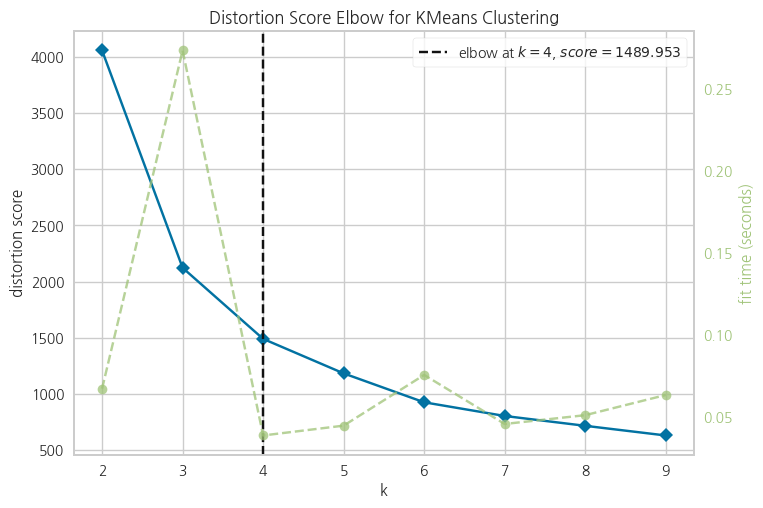

KElbowVisualizer(ax=<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>,
                 estimator=KMeans(n_clusters=9, random_state=42), k=(2, 10))

In [ ]:
kelbow_visualizer(KMeans(random_state=42), scaled_features, k=(2,10))

In [ ]:
# 엘보우 플롯에 따라 클러스터 그룹은 4로 설정
best_k = 4

kmeans = KMeans(n_clusters = best_k, random_state = 42)
segment['cluster'] = kmeans.fit_predict(scaled_features)
segment.head()

,R_경과일,F_거래횟수,M_총거래금액,R,F,M,cluster
고객ID,,,,,,,
USER_0000,108,2,26.84174,3,1,1,0
USER_0001,60,60,15204.23396,4,4,5,1
USER_0002,74,23,1534.63594,4,3,2,0
USER_0003,18,17,1397.71528,5,2,2,0
USER_0004,108,36,1437.83900,3,3,2,0


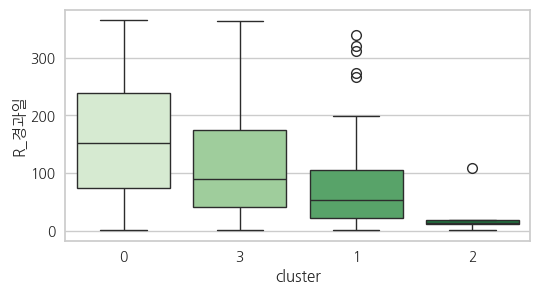

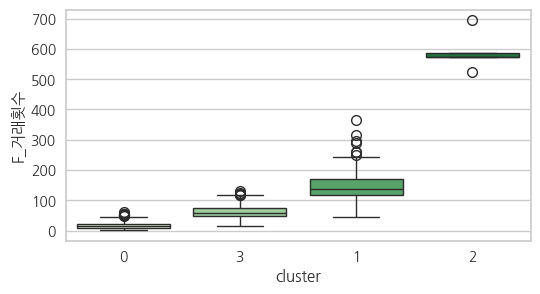

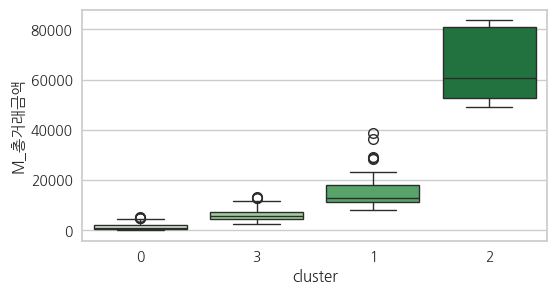

In [ ]:
for i,c in enumerate(list(segment.columns[:3])):
    plt.figure(figsize = (6,3))
    sns.boxplot(y = segment[c], x = segment['cluster'], order = [0,3,1,2], palette='Greens')
    plt.show()

- 4개로 나눈 클러스터를 R,F,M으로 나누어서 확인해보니 그룹간의 차이가 확실이 보인다.

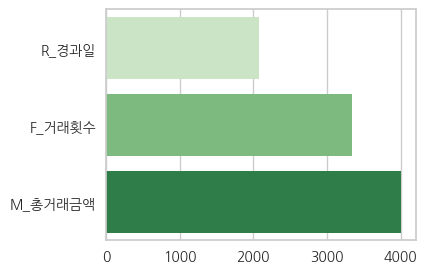

R_경과일: 0.22
F_거래횟수: 0.35
M_총거래금액: 0.42


In [ ]:
X = scaled_features
y = segment['cluster']

lgbm = LGBMClassifier(random_state = 42, verbose=-1)
lgbm.fit(X,y)

plt.figure(figsize = (4,3))
sns.barplot(x = lgbm.feature_importances_, y = X.columns, palette='Greens')
plt.ylabel('')
plt.show()

# 가중치 계산
scores = lgbm.feature_importances_ / sum(lgbm.feature_importances_)
for i,c in enumerate(X.columns):
    print(f'{c}: {round(scores[i],2)}')

- LGBClassifier모델을 종속변수를 Cluster설정 후 예측을 함으로써 feature_importance를 확인하였다.(RFM점수에 feature_importance를 기준으로 가중치를 부여해서 고객을 세분화한다.)

In [ ]:
# 고객 세분화 (standard, silver, gold, premium 순서)
def customer(RFM_Segment):
    if RFM_Segment <= 20:
        return 'Silver'
    elif RFM_Segment <= 40:
        return 'Silver'
    elif RFM_Segment <= 60:
        return 'Gold'
    elif RFM_Segment <= 80:
        return 'Platinum'
    else:
        return 'Diamond'

# 최종 RFM score 및 고객등급 산출
segment['RFM_score'] = (segment['R']*scores[0] + segment['F']*scores[1] + segment['M']*scores[2])/5*100
segment['고객등급'] = segment['RFM_score'].apply(customer)

In [ ]:
segment['고객등급'].value_counts(normalize = True).reindex(['Silver','Gold','Platinum','Diamond'])*100

Silver      34.673025
Gold        28.201635
Platinum    26.566757
Diamond     10.558583
Name: 고객등급, dtype: float64

In [ ]:
segment.groupby('고객등급')['M_총거래금액'].sum().sort_values() / segment['M_총거래금액'].sum()*100

고객등급
Silver       5.780499
Gold        16.465869
Platinum    36.188662
Diamond     41.564970
Name: M_총거래금액, dtype: float64

- 높은 등급(Platinum, Diamond)의 고객들은 적은 비중을 차지하지만, 전체 매출에서 큰 부분에 기여하고있다.

In [ ]:
# 세그먼트 시각화를 위한 전처리
def RFM_scale(df):
    temp = df.copy()

    # Recency
    temp['R_interval'] = pd.qcut(df['R_경과일'],
                                 q = [0, 0.2,0.4, 0.6, 0.8, 1])
    left = temp['R_interval'].apply(lambda x: x.left).astype(int)
    right =  temp['R_interval'].apply(lambda x: x.right).astype(int)

    df['R_scale'] = (temp['R']-1) + ((temp['R_경과일'] - left-0.01) / (right-left)) - 0.0001

    # Frequency
    temp['F_interval'] = pd.cut(df['F_거래횟수'],
                                bins = [0, 19, 39, 67, calculatet_outlier(df,'F_거래횟수'), max(df['F_거래횟수'])])
    left = temp['F_interval'].apply(lambda x: x.left).astype(int)
    right =  temp['F_interval'].apply(lambda x: x.right).astype(int)

    df['F_scale'] = (temp['F']-1) + ((temp['F_거래횟수'] - left-0.01) / (right-left)) - 0.0001

    # Monetary
    temp['M_interval'] = pd.cut(df['M_총거래금액'],
                                bins = [0, 1692, 3373, 6643, calculatet_outlier(df,'M_총거래금액'), max(df['M_총거래금액'])])
    left = temp['M_interval'].apply(lambda x: x.left).astype(int)
    right =  temp['M_interval'].apply(lambda x: x.right).astype(int)

    df['M_scale'] = (temp['M']-1) + ((temp['M_총거래금액'] - left) / (right-left))-0.0001

    return df

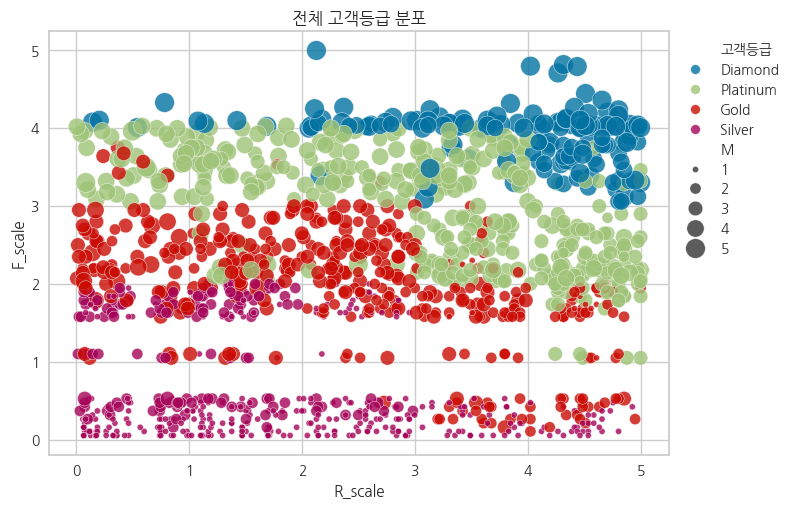

In [ ]:
segment= RFM_scale(segment)
sns.scatterplot(x = segment['R_scale'], y = segment['F_scale'], alpha = 0.8
                ,size = segment['M'], sizes = (20,200)
                ,hue = segment['고객등급'], hue_order = ['Diamond','Platinum','Gold','Silver']
               )
plt.legend(loc = 'upper left', bbox_to_anchor=(1, 1))
plt.title('전체 고객등급 분포')
plt.show()

# EDA

In [ ]:
# 그래프를 그릴때 순서를 통일하기 위한 order
area_order = ['California', 'Chicago', 'New York', 'New Jersey', 'Washington DC']

category_order = ['Accessories', 'Android', 'Apparel', 'Backpacks', 'Bags',
       'Bottles', 'Drinkware', 'Fun', 'Gift Cards', 'Google', 'Headgear',
       'Housewares', 'Lifestyle', 'More Bags', 'Nest', 'Nest-Canada',
       'Nest-USA', 'Notebooks & Journals', 'Office', 'Waze']

date_order = [ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]

coupon_order = ['Clicked', 'Used', 'Not Used']

day_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

grade_order = ["Silver", "Gold", "Platinum", "Diamond"]

season_order = ["봄", "여름", "가을", "겨울"]

In [ ]:
# RFM 결과를 dat_raw에 merge 함으로써 고객별 EDA에 고객등급을 이용할 수 있다.

dat_raw = dat_raw.merge(segment, on="고객ID", how="left")
dat_raw.drop(["R_경과일", "F_거래횟수", "M_총거래금액", "RFM_score", "R", "F", "M", "cluster", "R_scale",	"F_scale","M_scale"], axis=1, inplace=True)
dat_raw.head()

,고객ID,거래ID,거래날짜,제품ID,제품카테고리,수량,평균금액,배송료,쿠폰상태,성별,...,요일,할인금액,거래금액,계절,최소거래월,최대거래월,고객수명,오프라인비용,온라인비용,고객등급
0,USER_1358,Transaction_0000,2019-01-01,Product_0981,Nest-USA,1,153.71,6.50,Used,남,...,Tuesday,16.9081,158.6729,겨울,1,1,1,4500,2424.5,Diamond
1,USER_1358,Transaction_0001,2019-01-01,Product_0981,Nest-USA,1,153.71,6.50,Used,남,...,Tuesday,16.9081,158.6729,겨울,1,1,1,4500,2424.5,Diamond
2,USER_1358,Transaction_0002,2019-01-01,Product_0904,Office,1,2.05,6.50,Used,남,...,Tuesday,0.2255,8.5295,겨울,1,1,1,4500,2424.5,Diamond
3,USER_1358,Transaction_0003,2019-01-01,Product_0203,Apparel,5,17.53,0.06,Not Used,남,...,Tuesday,0.0000,103.4870,겨울,1,1,1,4500,2424.5,Diamond
4,USER_1358,Transaction_0003,2019-01-01,Product_0848,Bags,1,16.50,0.06,Used,남,...,Tuesday,1.9470,17.5830,겨울,1,1,1,4500,2424.5,Diamond


In [ ]:
# 고객별로 데이터를 분석하기 위한 준비
user_df = dat_raw.groupby("고객ID").agg({"거래금액" : "sum", "거래ID" : "count", "배송료":"sum", "고객지역":"first", "성별":"first",
                                       "제품ID":"nunique", "제품카테고리":"nunique", "할인금액" : "mean", "고객등급":"first"}).rename(columns={"거래금액":"총거래금액", "거래ID":"구매횟수"})
user_df["구매당_평균_배송료"] = user_df["배송료"] / user_df["구매횟수"]
user_df

,총거래금액,구매횟수,배송료,고객지역,성별,제품ID,제품카테고리,할인금액,고객등급,구매당_평균_배송료
고객ID,,,,,,,,,,
USER_0000,26.84174,2,1.86,New York,여,2,2,5.353230,Silver,0.930000
USER_0001,15204.23396,60,182.53,New York,남,42,10,14.685051,Diamond,3.042167
USER_0002,1534.63594,23,42.23,California,남,21,6,6.665863,Gold,1.836087
USER_0003,1397.71528,17,58.16,California,남,11,4,9.928172,Gold,3.421176
USER_0004,1437.83900,36,67.90,Chicago,여,33,7,6.230300,Gold,1.886111
...,...,...,...,...,...,...,...,...,...,...
USER_1463,595.68600,7,13.33,California,여,7,4,1.886314,Silver,1.904286
USER_1464,2460.54372,40,76.42,New York,남,35,11,6.402422,Platinum,1.910500
USER_1465,116.28750,8,0.88,Chicago,남,8,2,0.522363,Silver,0.110000


### 고객등급에 따른 고객분석

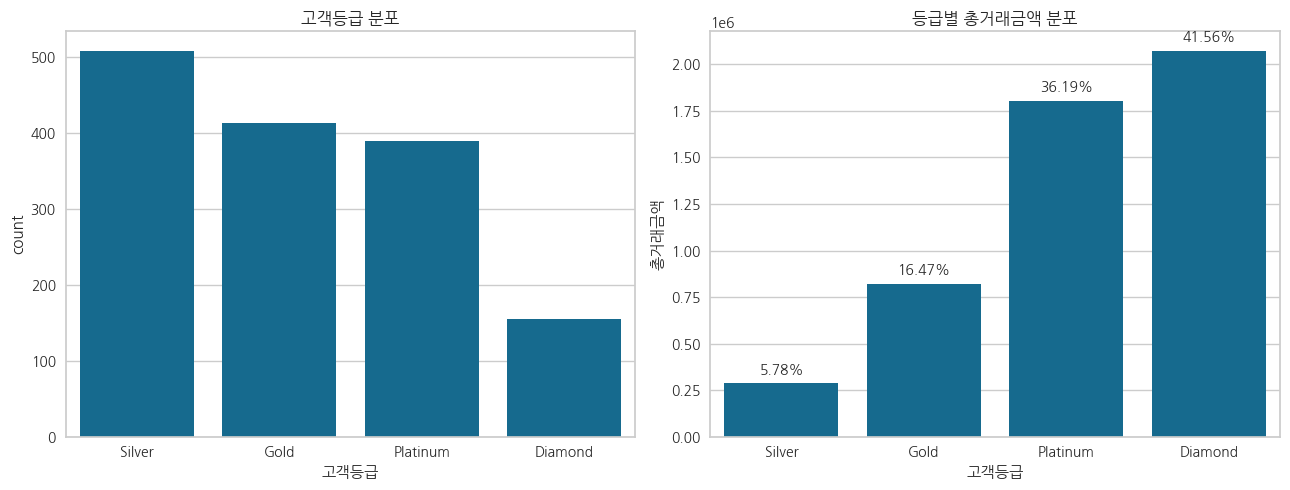

In [ ]:
plt.figure(figsize=(13,5))

plt.subplot(1,2,1)
plt.title("고객등급 분포")
sns.countplot(data=user_df, x="고객등급", order=grade_order)

plt.subplot(1,2,2)
plt.title("등급별 총거래금액 분포")
ax = sns.barplot(data=user_df, x="고객등급", y="총거래금액", order=grade_order, estimator=sum, ci=None)

# 전체 데이터셋의 총 거래금액 계산
total_transaction = user_df['총거래금액'].sum()

# 각 막대의 높이에 대한 비율 계산하여 표시
for p in ax.patches:
    height = p.get_height()
    percentage = (height / total_transaction) * 100
    ax.text(p.get_x() + p.get_width() / 2., height + total_transaction * 0.01, '{:.2f}%'.format(percentage), ha="center")

plt.tight_layout()
plt.show()

등급이 높은 고객이 중요한 이유

<Axes: xlabel='고객등급', ylabel='배송료'>

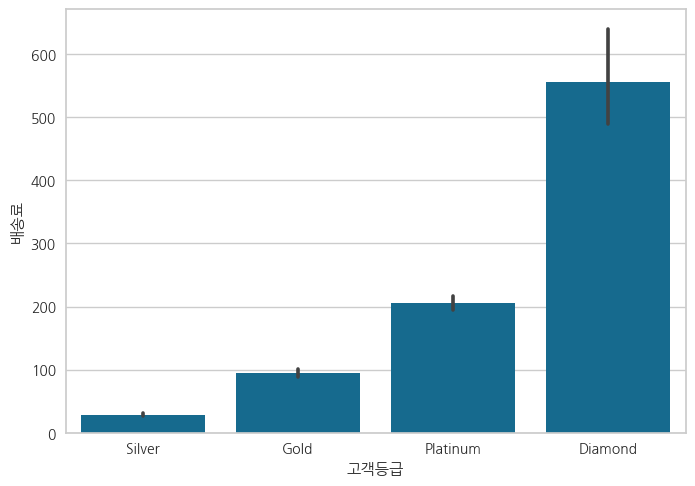

In [ ]:
sns.barplot(data=user_df, x="고객등급", y="배송료", order=grade_order)

<Axes: xlabel='고객등급', ylabel='구매당_평균_배송료'>

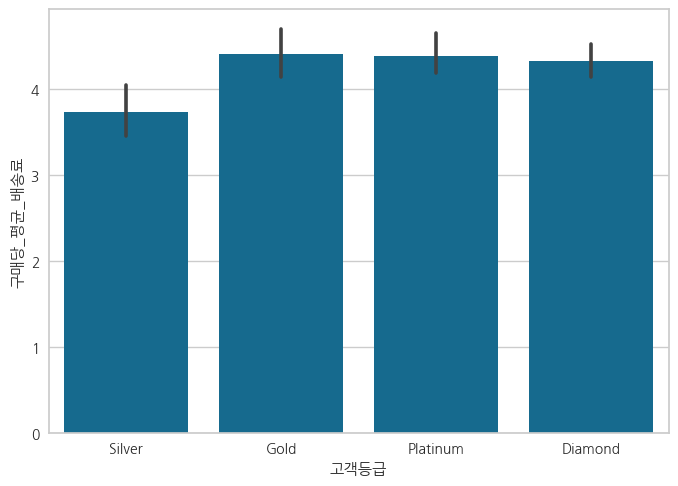

In [ ]:
sns.barplot(data=user_df, x="고객등급", y="구매당_평균_배송료", order=["Silver", "Gold", "Platinum", "Diamond"])

- 등급이 높을수록 배송비의 평균이 많이 나왔다.
- 배송횟수가 많아서 배송비의 평균이 높았을 확률 고려해야한다.

-> 구매횟수로 나눠보니 등급별로 배송비는 비슷하게 내고있다는 것을 확인했다.

<Axes: xlabel='고객등급', ylabel='할인금액'>

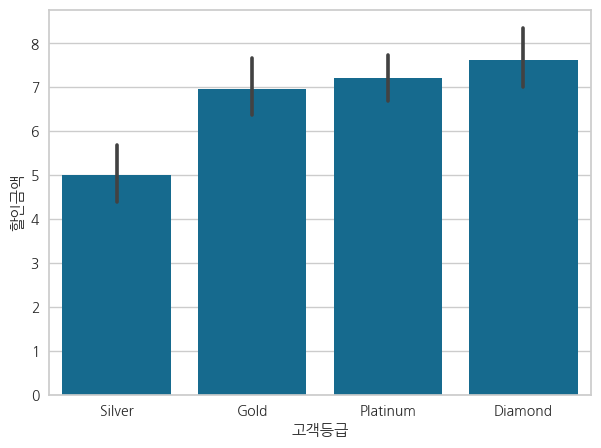

In [ ]:
plt.figure(figsize=(7,5))
sns.barplot(data=user_df, x="고객등급", y="할인금액", order=["Silver", "Gold", "Platinum", "Diamond"])

- 등급이 높을수록 할인금액에 대한 평균이 크다.-> 할인에 등급별 분포를 확인해보면 좋을거같다.

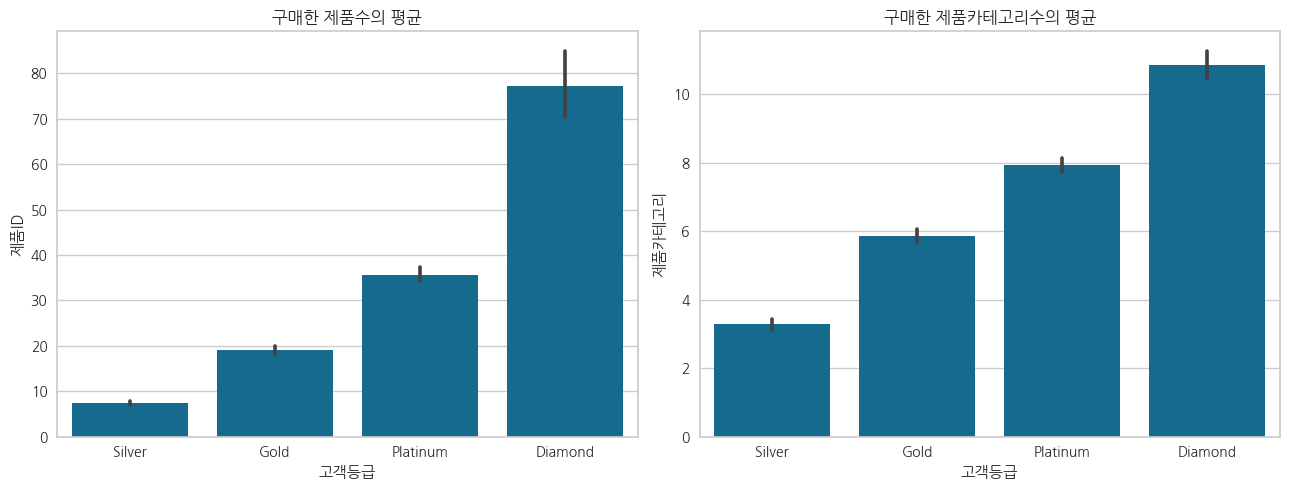

In [ ]:
plt.figure(figsize=(13,5))

plt.subplot(1,2,1)
sns.barplot(data=user_df, x="고객등급", y="제품ID", order=["Silver", "Gold", "Platinum", "Diamond"])
plt.title("구매한 제품수의 평균")

plt.subplot(1,2,2)
sns.barplot(data=user_df, x="고객등급", y="제품카테고리", order=["Silver", "Gold", "Platinum", "Diamond"])
plt.title("구매한 제품카테고리수의 평균")

plt.tight_layout()

- 등급을 높이는데는 다양한 제품과 카테고리를 경험하는 것이 중요하다 -> 더많은 제품과 카테고리를 추천할 수 있으면 좋을거같다.

### 고객등급에 따른 거래분석

In [ ]:
Silver = dat_raw[dat_raw["고객등급"] == "Silver"].copy()
Gold = dat_raw[dat_raw["고객등급"] == "Gold"].copy()
Platinum = dat_raw[dat_raw["고객등급"] == "Platinum"].copy()
Diamond = dat_raw[dat_raw["고객등급"] == "Diamond"].copy()

- 등급별로 데이터를 나눠서 확인

In [ ]:
print(f"Silver의 CLV : {clv(Silver)}")
print(f"Gold의 CLV : {clv(Gold)}")
print(f"Platinum의 CLV : {clv(Platinum)}")
print(f"Diamond의 CLV : {clv(Diamond)}")

Silver의 CLV : 1008.94
Gold의 CLV : 4787.49
Platinum의 CLV : 18985.56
Diamond의 CLV : 103949.48


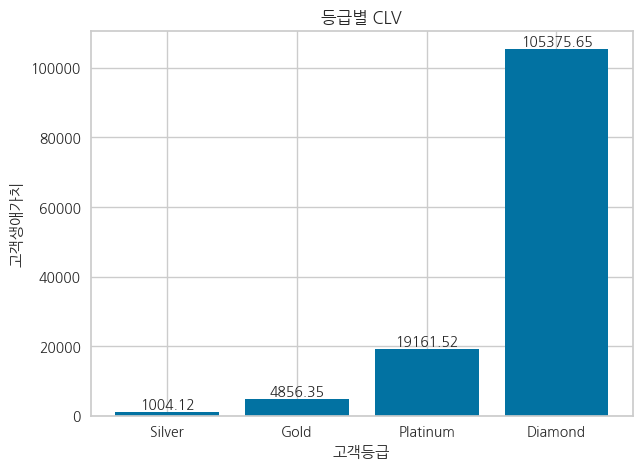

In [ ]:
plt.figure(figsize=(7,5))

x = ["Silver", "Gold", "Platinum", "Diamond"]
y = [1004.12, 4856.35, 19161.52, 105375.65]

plt.bar(x, y)
plt.xlabel('고객등급')
plt.ylabel('고객생애가치')
plt.title('등급별 CLV')

for i in range(len(x)):
    plt.text(i, y[i] + 1000, str(y[i]), ha='center')

plt.show()

- 고객등급별로 CLV(고객생애가치)를 확인해보니, 고객등급이 높아질수록 CLV가 많이 증가하는 것이 보임
- 마케팅 목표
1. 실버 -> 브론즈 -> 플레 -> 다이아로 고객의 등급을 향상시킨다.
2. 다이아몬드 고객의 이탈을 막는다.

### 고객별 마케팅 금액 분포와 요일,월,계절별 구매금액 분포 비교

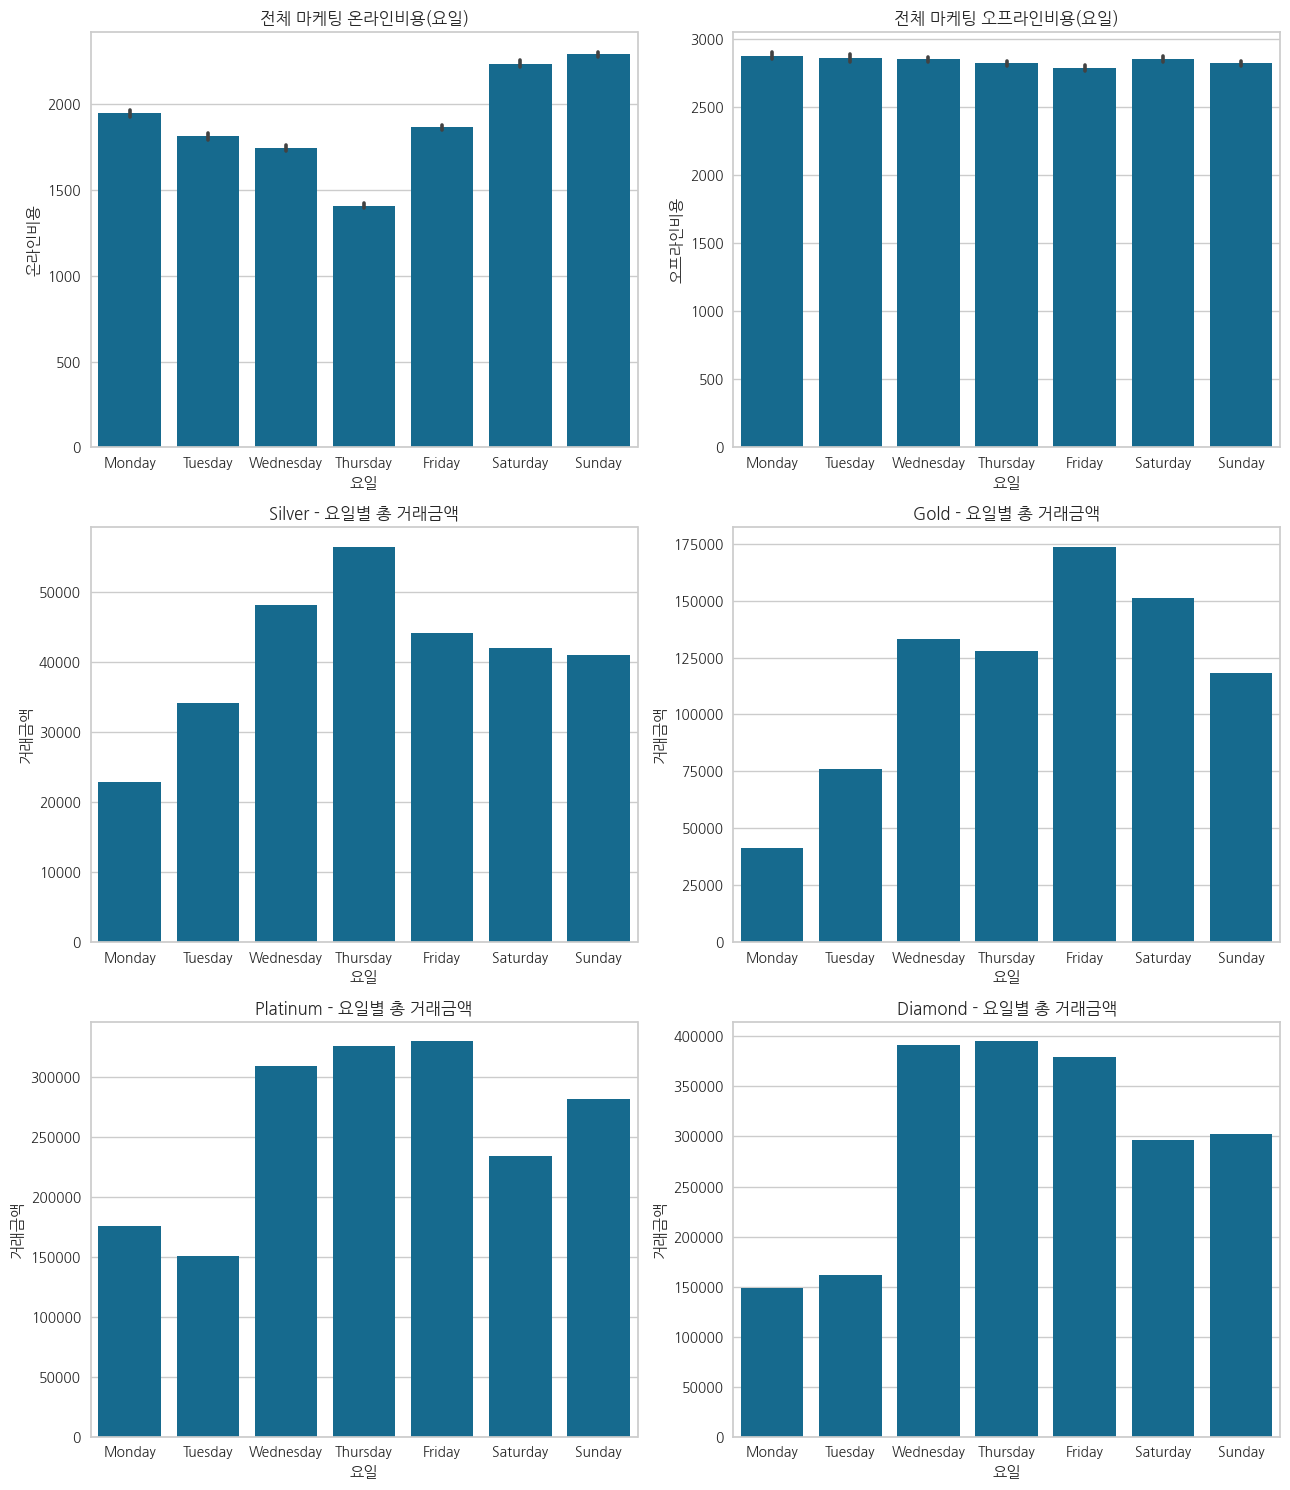

In [ ]:
plt.figure(figsize=(13,15))

plt.subplot(3,2,1)
sns.barplot(data=dat_raw, x="요일", y="온라인비용", order=day_order)
plt.title("전체 마케팅 온라인비용(요일)")

plt.subplot(3,2,2)
sns.barplot(data=dat_raw, x="요일", y="오프라인비용", order=day_order)
plt.title("전체 마케팅 오프라인비용(요일)")

plt.subplot(3,2,3)
Silver_day_value = Silver.groupby('요일')['거래금액'].sum().reset_index()
sns.barplot(data=Silver_day_value, x='요일', y='거래금액', order=day_order)
plt.title("Silver - 요일별 총 거래금액")

plt.subplot(3,2,4)
Gold_day_value = Gold.groupby('요일')['거래금액'].sum().reset_index()
sns.barplot(data=Gold_day_value, x='요일', y='거래금액', order=day_order)
plt.title("Gold - 요일별 총 거래금액")

plt.subplot(3,2,5)
Platinum_day_value = Platinum.groupby('요일')['거래금액'].sum().reset_index()
sns.barplot(data=Platinum_day_value, x='요일', y='거래금액', order=day_order)
plt.title("Platinum - 요일별 총 거래금액")

plt.subplot(3,2,6)
Diamond_day_value = Diamond.groupby('요일')['거래금액'].sum().reset_index()
sns.barplot(data=Diamond_day_value, x='요일', y='거래금액', order=day_order)
plt.title("Diamond - 요일별 총 거래금액")

plt.tight_layout()

그래프로 확인해보았을때는 마케팅이 효과가없는것으로 확인된다.

"요일"이라는 속성은 이제 속성별로 어떤 날에 추천을 하면 좋을지 이용하면 좋을거같다.

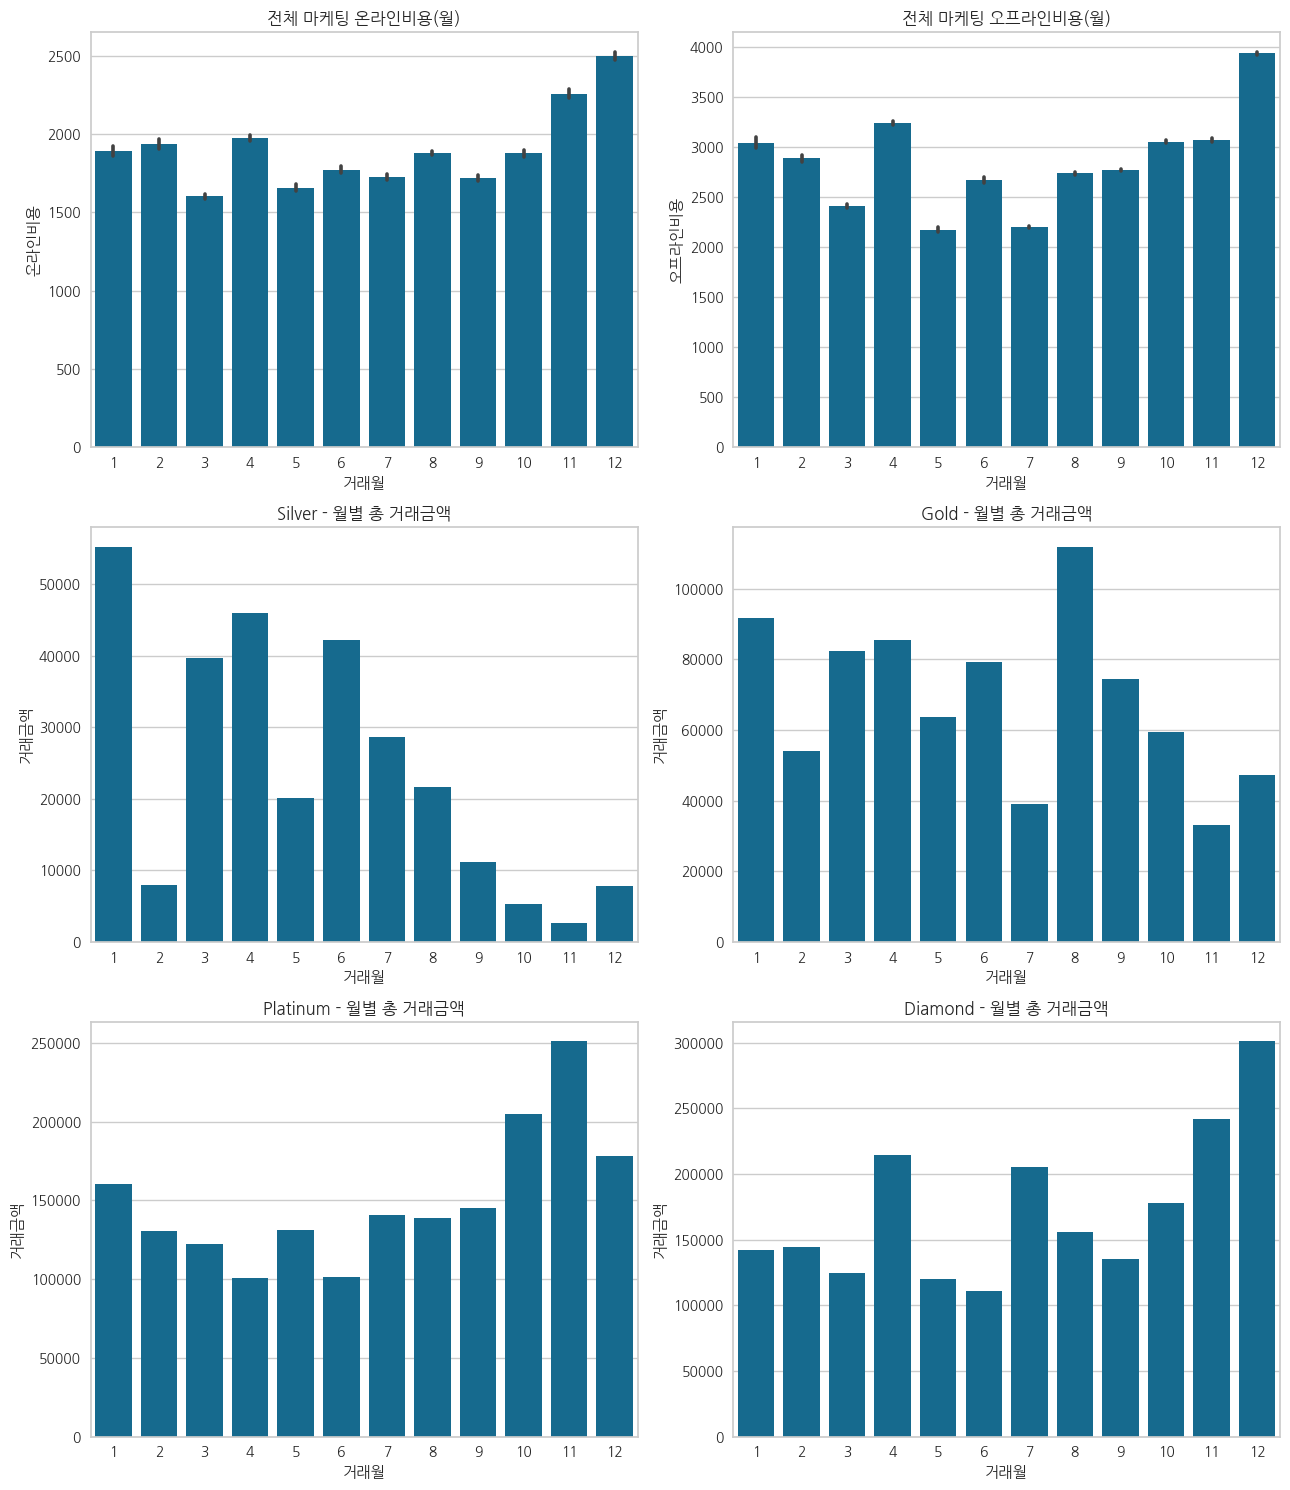

In [ ]:
plt.figure(figsize=(13,15))

plt.subplot(3,2,1)
sns.barplot(data=dat_raw, x="거래월", y="온라인비용", order=date_order)
plt.title("전체 마케팅 온라인비용(월)")

plt.subplot(3,2,2)
sns.barplot(data=dat_raw, x="거래월", y="오프라인비용", order=date_order)
plt.title("전체 마케팅 오프라인비용(월)")

plt.subplot(3,2,3)
Silver_day_value = Silver.groupby('거래월')['거래금액'].sum().reset_index()
sns.barplot(data=Silver_day_value, x='거래월', y='거래금액', order=date_order)
plt.title("Silver - 월별 총 거래금액")

plt.subplot(3,2,4)
Gold_day_value = Gold.groupby('거래월')['거래금액'].sum().reset_index()
sns.barplot(data=Gold_day_value, x='거래월', y='거래금액', order=date_order)
plt.title("Gold - 월별 총 거래금액")

plt.subplot(3,2,5)
Platinum_day_value = Platinum.groupby('거래월')['거래금액'].sum().reset_index()
sns.barplot(data=Platinum_day_value, x='거래월', y='거래금액', order=date_order)
plt.title("Platinum - 월별 총 거래금액")

plt.subplot(3,2,6)
Diamond_day_value = Diamond.groupby('거래월')['거래금액'].sum().reset_index()
sns.barplot(data=Diamond_day_value, x='거래월', y='거래금액', order=date_order)
plt.title("Diamond - 월별 총 거래금액")

plt.tight_layout()

그래프로 봤을때는 실버, 골드는 분포를 따르지 않는것으로 보이고, 플레티넘과 다이아는 마케팅 분포와 어느정도 비슷함이 보인다.
월별 마케팅을 했을때, 플레티넘과 다이아만 좀 효과가 나타나는거같다. 실버나 골드는 다른 마케팅 방법을 찾아봐야할듯!

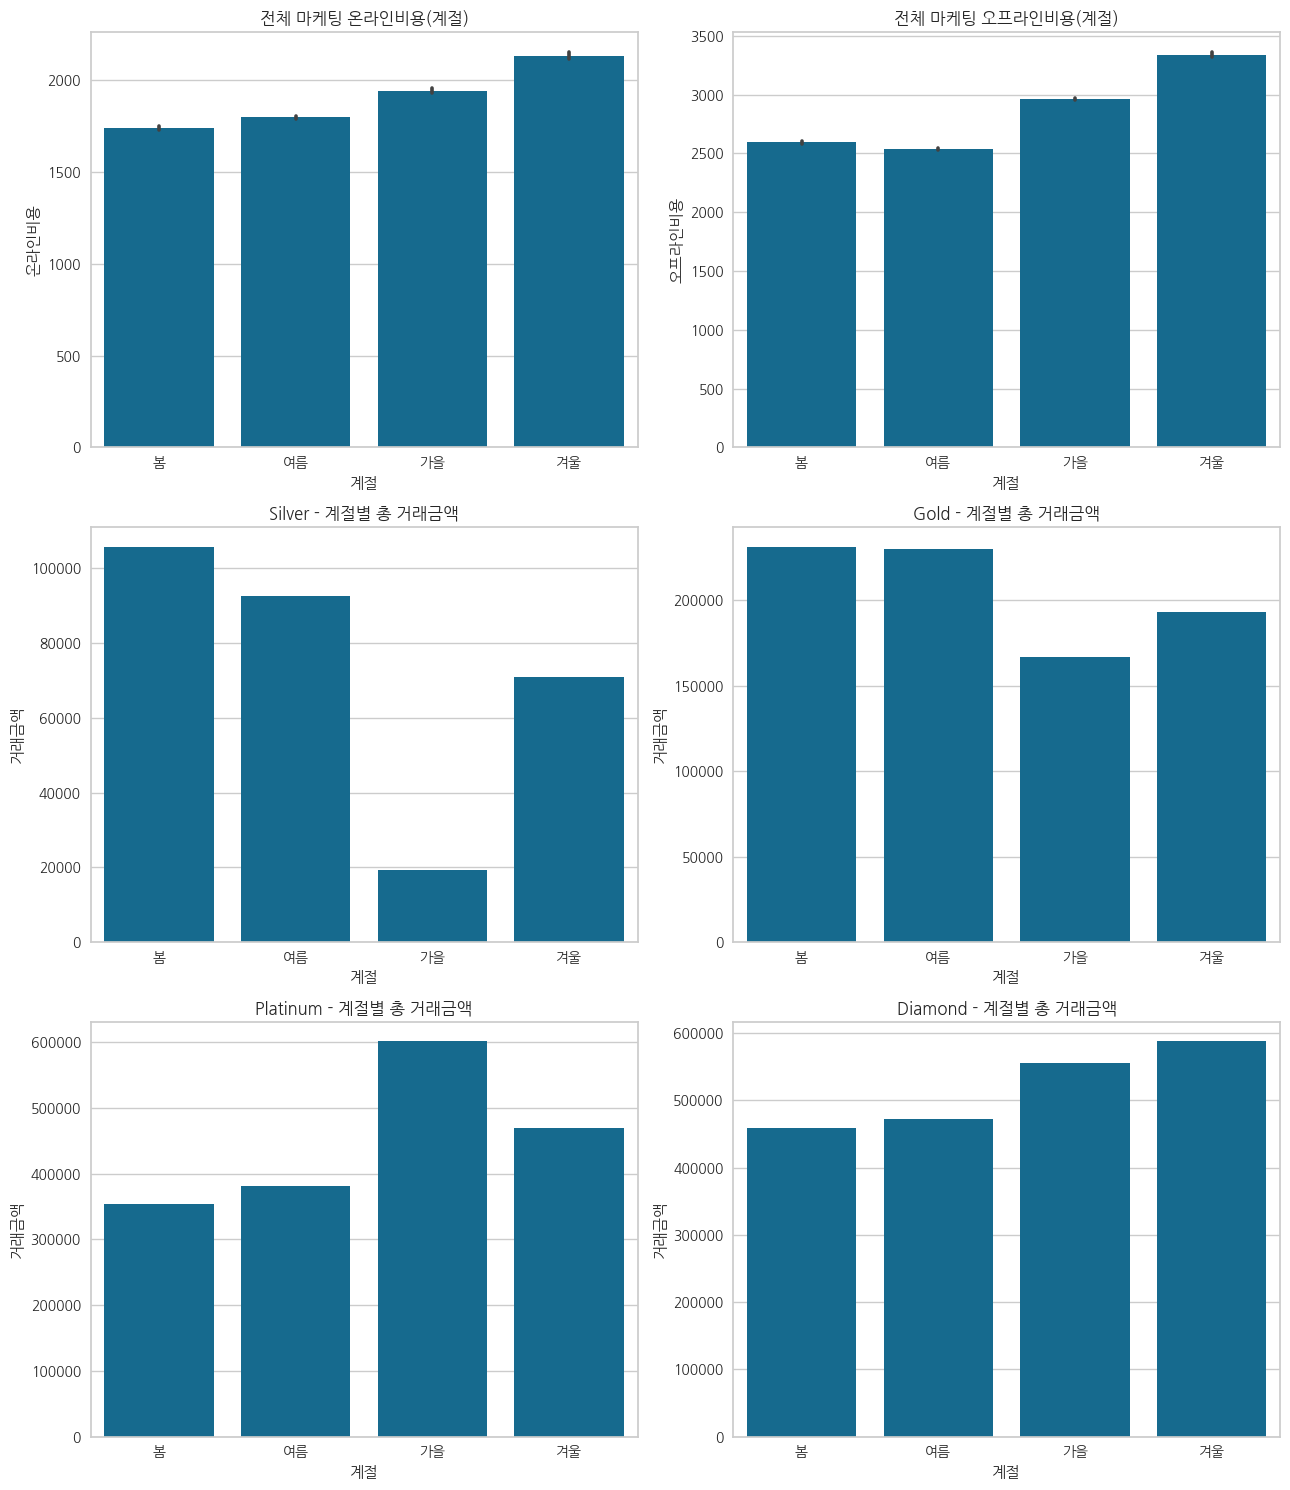

In [ ]:
plt.figure(figsize=(13,15))

plt.subplot(3,2,1)
sns.barplot(data=dat_raw, x="계절", y="온라인비용", order=season_order)
plt.title("전체 마케팅 온라인비용(계절)")

plt.subplot(3,2,2)
sns.barplot(data=dat_raw, x="계절", y="오프라인비용", order=season_order)
plt.title("전체 마케팅 오프라인비용(계절)")

plt.subplot(3,2,3)
Silver_day_value = Silver.groupby('계절')['거래금액'].sum().reset_index()
sns.barplot(data=Silver_day_value, x='계절', y='거래금액', order=season_order)
plt.title("Silver - 계절별 총 거래금액")

plt.subplot(3,2,4)
Gold_day_value = Gold.groupby('계절')['거래금액'].sum().reset_index()
sns.barplot(data=Gold_day_value, x='계절', y='거래금액', order=season_order)
plt.title("Gold - 계절별 총 거래금액")

plt.subplot(3,2,5)
Platinum_day_value = Platinum.groupby('계절')['거래금액'].sum().reset_index()
sns.barplot(data=Platinum_day_value, x='계절', y='거래금액', order=season_order)
plt.title("Platinum - 계절별 총 거래금액")

plt.subplot(3,2,6)
Diamond_day_value = Diamond.groupby('계절')['거래금액'].sum().reset_index()
sns.barplot(data=Diamond_day_value, x='계절', y='거래금액', order=season_order)
plt.title("Diamond - 계절별 총 거래금액")

plt.tight_layout()

요일, 월, 계절별로 마케팅금액과 총거래금액의 분포를 비교했다.

요일은 대체적으로 다 달랐지만, 월과 계절의 분포를 보니 실버와 골드는 마케팅에 영향을 받지 않는 그룹임을 알았다.
그리고 플레티넘과 다이아는 마케팅에 영향을 많이 받는데,
특히 영향을 제일 잘 받는 그룹은 다이아그룹이다.

마케팅은 다이아그룹을 향해서 주도하는 것이 좋을거같고, 플레티넘은 마케팅을 잘 따라오게 만들면 다이아그룹으로의 상승을 노려볼 수 있을거같다.

### 등급별 월별 거래횟수와 리텐션을 확인한다.

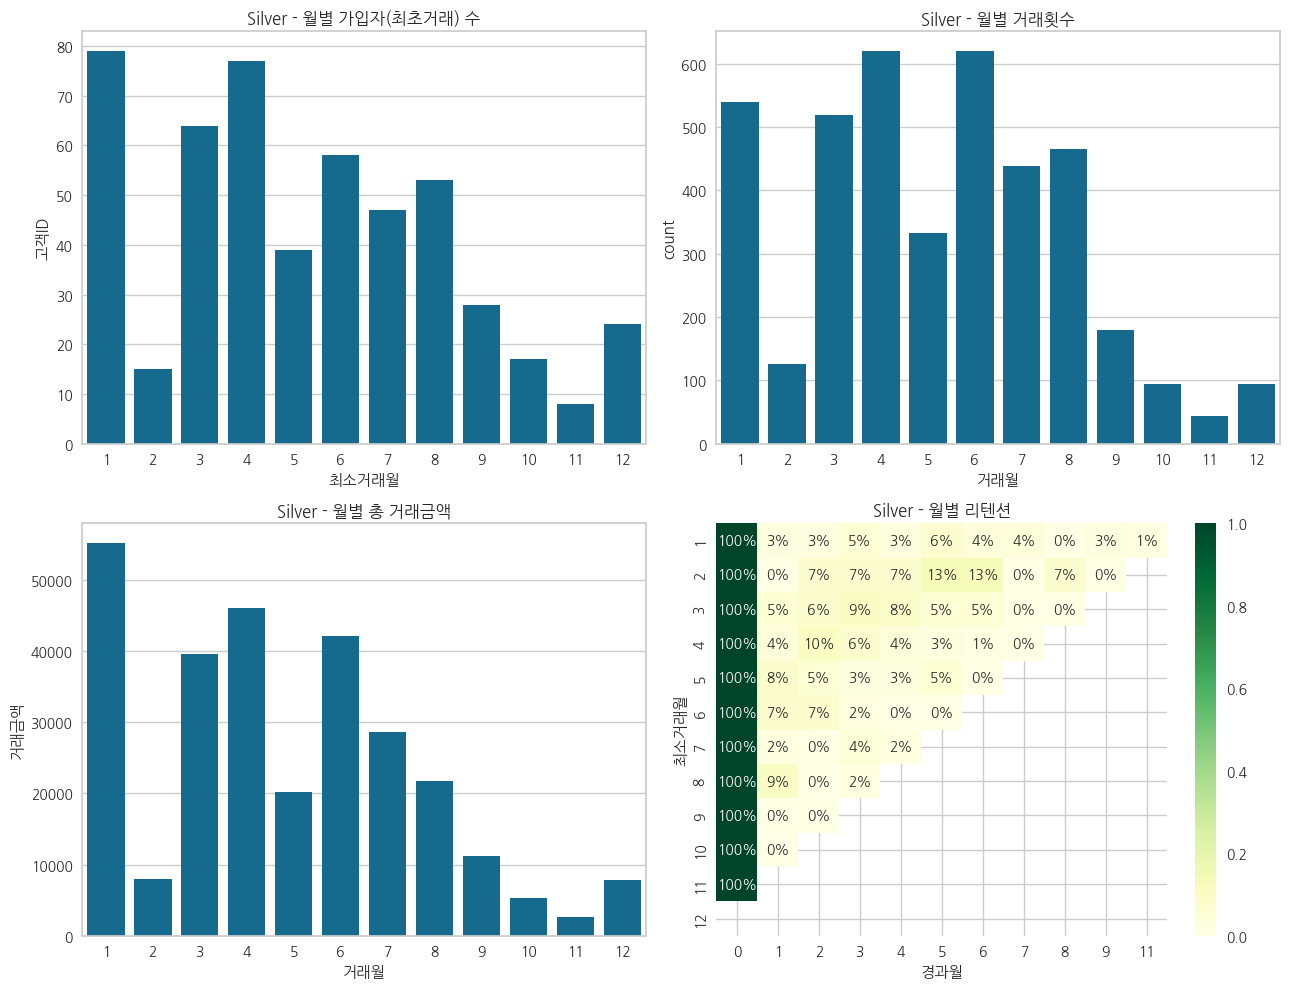

In [ ]:
plt.figure(figsize=(13,10))

plt.subplot(2,2,1)
monthly_count = Silver.groupby('최소거래월')['고객ID'].nunique().reset_index()
sns.barplot(data=monthly_count, x='최소거래월', y='고객ID')
plt.title("Silver - 월별 가입자(최초거래) 수")

plt.subplot(2,2,2)
sns.countplot(data=Silver, x="거래월", order=date_order)
plt.title("Silver - 월별 거래횟수")

plt.subplot(2,2,3)
monthly_value = Silver.groupby('거래월')['거래금액'].sum().reset_index()
sns.barplot(data=monthly_value, x='거래월', y='거래금액')
plt.title("Silver - 월별 총 거래금액")

plt.subplot(2,2,4)
plot_retention(Silver)
plt.title("Silver - 월별 리텐션")

plt.tight_layout()

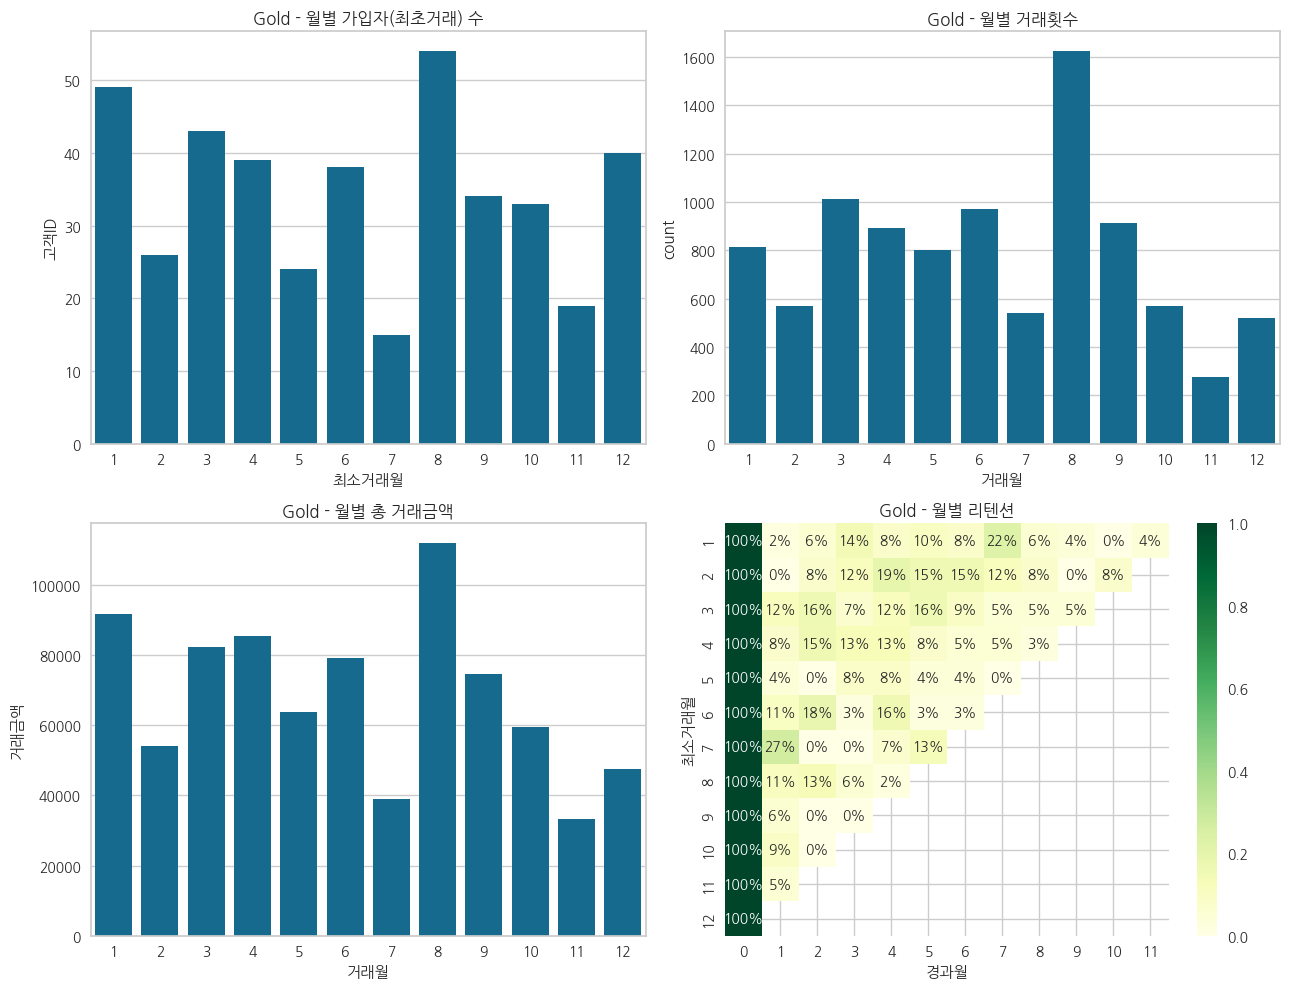

In [ ]:
plt.figure(figsize=(13,10))

plt.subplot(2,2,1)
monthly_count = Gold.groupby('최소거래월')['고객ID'].nunique().reset_index()
sns.barplot(data=monthly_count, x='최소거래월', y='고객ID')
plt.title("Gold - 월별 가입자(최초거래) 수")

plt.subplot(2,2,2)
sns.countplot(data=Gold, x="거래월", order=date_order)
plt.title("Gold - 월별 거래횟수")

plt.subplot(2,2,3)
monthly_value = Gold.groupby('거래월')['거래금액'].sum().reset_index()
sns.barplot(data=monthly_value, x='거래월', y='거래금액')
plt.title("Gold - 월별 총 거래금액")

plt.subplot(2,2,4)
plot_retention(Gold)
plt.title("Gold - 월별 리텐션")

plt.tight_layout()

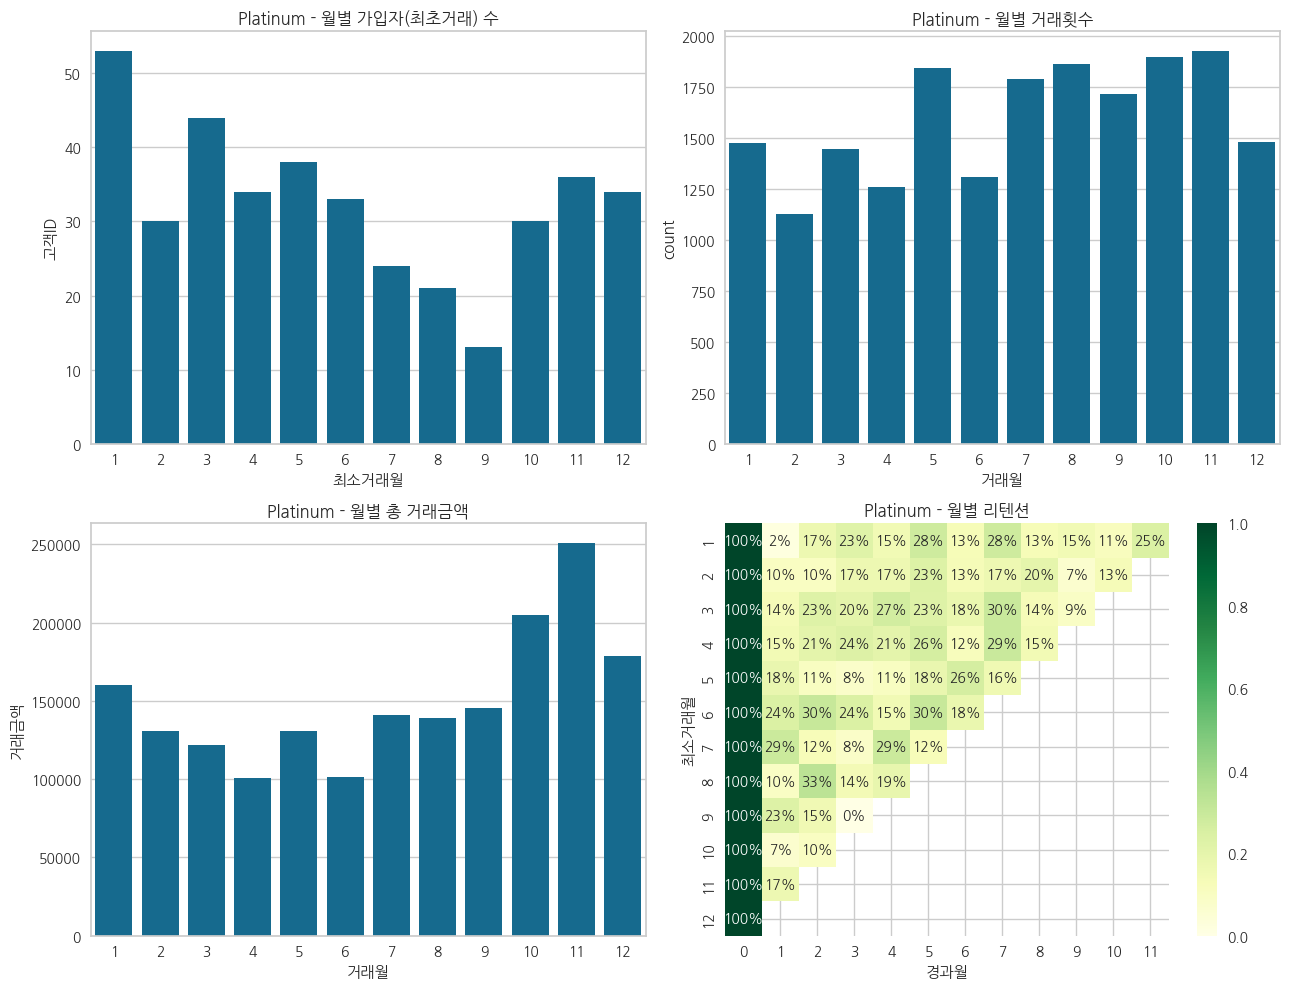

In [ ]:
plt.figure(figsize=(13,10))

plt.subplot(2,2,1)
monthly_count = Platinum.groupby('최소거래월')['고객ID'].nunique().reset_index()
sns.barplot(data=monthly_count, x='최소거래월', y='고객ID')
plt.title("Platinum - 월별 가입자(최초거래) 수")

plt.subplot(2,2,2)
sns.countplot(data=Platinum, x="거래월", order=date_order)
plt.title("Platinum - 월별 거래횟수")

plt.subplot(2,2,3)
monthly_value = Platinum.groupby('거래월')['거래금액'].sum().reset_index()
sns.barplot(data=monthly_value, x='거래월', y='거래금액')
plt.title("Platinum - 월별 총 거래금액")

plt.subplot(2,2,4)
plot_retention(Platinum)
plt.title("Platinum - 월별 리텐션")

plt.tight_layout()

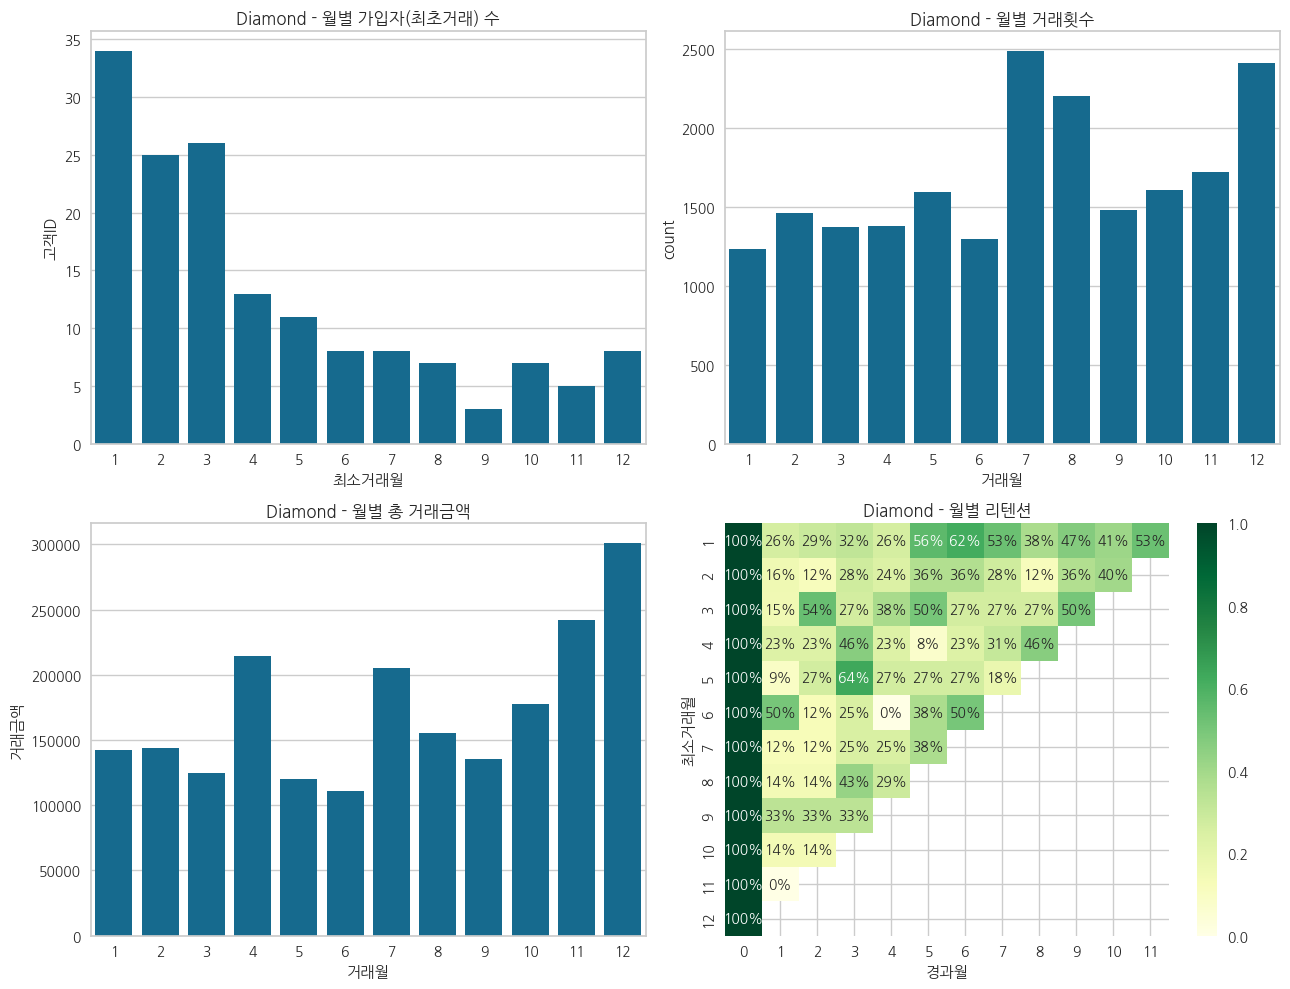

In [ ]:
plt.figure(figsize=(13,10))

plt.subplot(2,2,1)
monthly_count = Diamond.groupby('최소거래월')['고객ID'].nunique().reset_index()
sns.barplot(data=monthly_count, x='최소거래월', y='고객ID')
plt.title("Diamond - 월별 가입자(최초거래) 수")

plt.subplot(2,2,2)
sns.countplot(data=Diamond, x="거래월", order=date_order)
plt.title("Diamond - 월별 거래횟수")

plt.subplot(2,2,3)
monthly_value = Diamond.groupby('거래월')['거래금액'].sum().reset_index()
sns.barplot(data=monthly_value, x='거래월', y='거래금액')
plt.title("Diamond - 월별 총 거래금액")

plt.subplot(2,2,4)
plot_retention(Diamond)
plt.title("Diamond - 월별 리텐션")

plt.tight_layout()

일단 실버, 골드의 경우에는 최초거래를 한날, 거래 횟수가 많다 -> 가입하기위한 구매, 재구매가 잘 안이루어짐

플레티넘, 다이아몬드 같은경우는 가입은 연초에 다 이루어졌고, 후반으로 갈수록 가입자가 없는데, 거래횟수는 가입자에 상관없이 점점 많아졌다. -> 재구매가좋음

꾸준한 재구매를 유도하는 것이 등급상승에 도움이 된다.

###상위제품 구매고객 분석

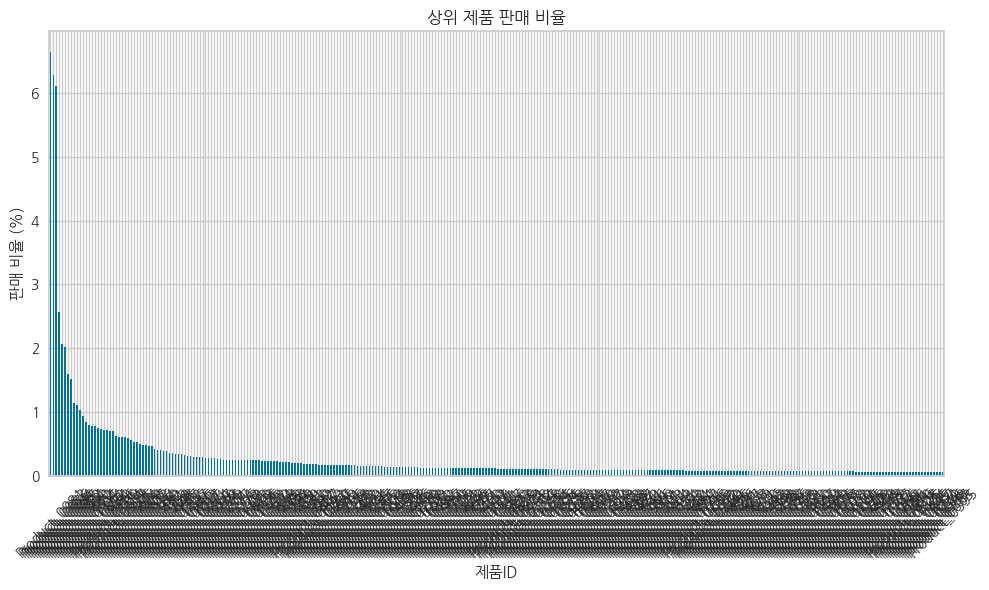

In [ ]:
top_products = dat_raw["제품ID"].value_counts(normalize=True)[:300] * 100

# 막대 그래프
plt.figure(figsize=(10, 6))
top_products.plot(kind='bar')
plt.xlabel('제품ID')
plt.ylabel('판매 비율 (%)')
plt.title('상위 제품 판매 비율')
plt.xticks(rotation=45)  # x축 레이블 회전
plt.tight_layout()
plt.show()

In [ ]:
dat_raw["제품ID"].value_counts(normalize=True)[:8] * 100

Product_0981    6.634041
Product_0983    6.288262
Product_0976    6.103091
Product_0984    2.571612
Product_0989    2.057668
Product_0985    2.012320
Product_0992    1.594740
Product_0904    1.522939
Name: 제품ID, dtype: float64

In [ ]:
# 상위?% 제품을 구매한 기록이 있는 고객들로 데이터프레임 생성

high_product = dat_raw["제품ID"].value_counts(normalize=True)[:8].index
user_list = dat_raw[dat_raw["제품ID"].isin(high_product)]["고객ID"].unique()

high_user = user_df[user_df.index.isin(user_list)].copy()
not_high_user = user_df[~user_df.index.isin(user_list)].copy()

In [ ]:
high_user["고객등급"].value_counts(normalize=True)

Gold        0.314353
Platinum    0.304212
Silver      0.260530
Diamond     0.120905
Name: 고객등급, dtype: float64

In [ ]:
not_high_user["고객등급"].value_counts(normalize=True)

Silver    0.94086
Gold      0.05914
Name: 고객등급, dtype: float64

상위 ?% 의 제품을 경험해본 그룹과 경험해보지 못한 그룹에서 극명한 차이가 보인다.
저 제품들을 실버와 브론즈들에게 경험시켜주는 것이 플레티넘이상으로 끌고올 수 있는 차이가 될 수 있을거같다.

In [ ]:
# high_user["고객지역"].value_counts(normalize=True)

In [ ]:
# not_high_user["고객지역"].value_counts(normalize=True)

지역에서는 차이를 볼 수 없었다.

In [ ]:
many_products = []
little_products = []

for category in category_order:
  category_df = dat_raw[dat_raw["제품카테고리"] == category]
  if category_df["제품ID"].nunique() > 7:
    many_products.append(category)
  else:
    little_products.append(category)

print(f"품목이 7개 초과인 카테고리 : {many_products}")
print(f"품목이 7개 이하인 카테고리 : {little_products}")

품목이 7개 초과인 카테고리 : ['Apparel', 'Bags', 'Drinkware', 'Headgear', 'Lifestyle', 'Nest', 'Nest-USA', 'Notebooks & Journals', 'Office', 'Waze']
품목이 7개 이하인 카테고리 : ['Accessories', 'Android', 'Backpacks', 'Bottles', 'Fun', 'Gift Cards', 'Google', 'Housewares', 'More Bags', 'Nest-Canada']


many_products에 대한 분석

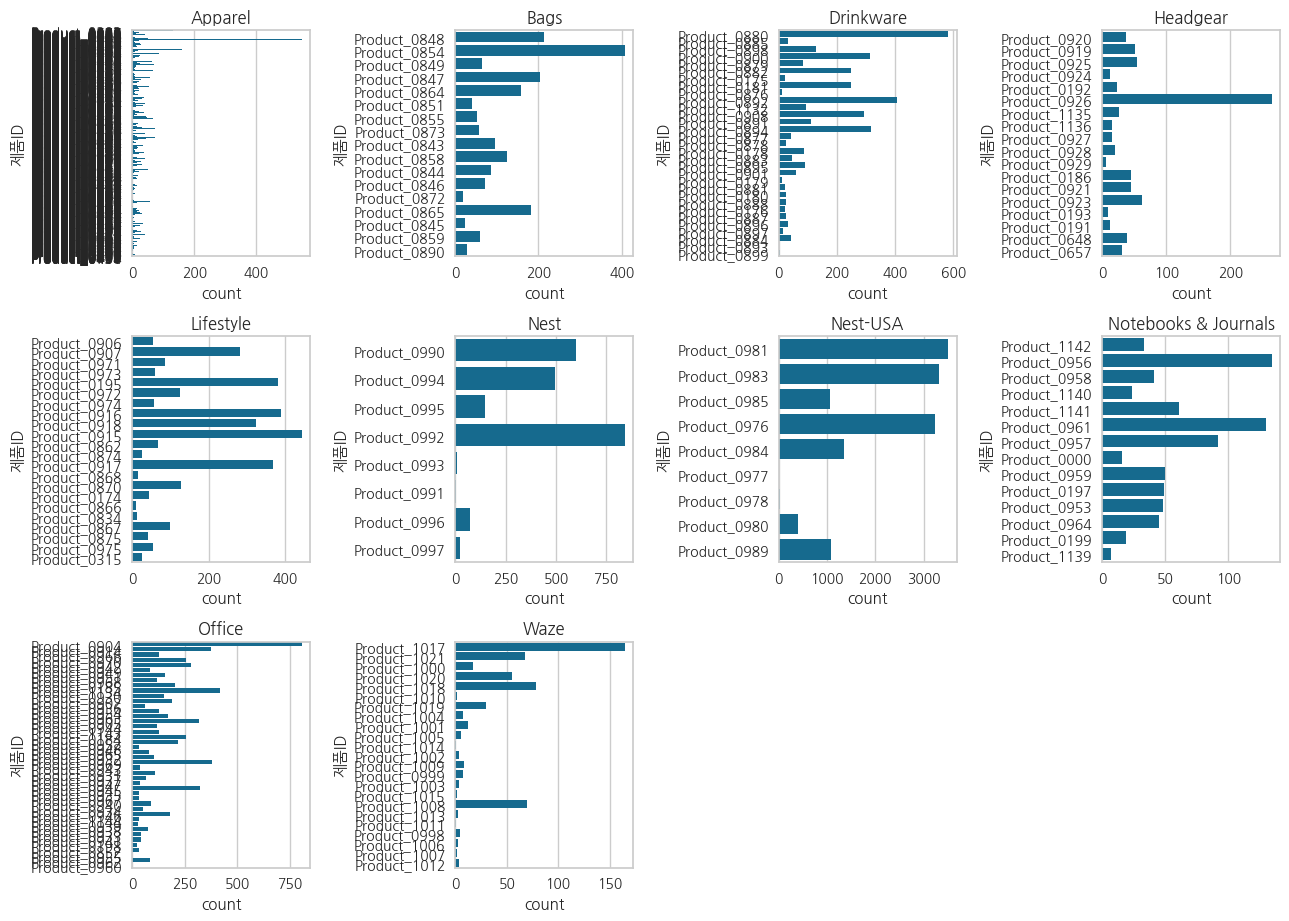

In [ ]:
plt.figure(figsize=(13,15))

for i,columns in enumerate(many_products):
  dat = dat_raw[dat_raw["제품카테고리"] == columns]
  plt.subplot(5,4,i+1)
  plt.title(columns)
  sns.countplot(data=dat, y="제품ID")

plt.tight_layout()

In [ ]:
# category_order = ['Accessories','Android', 'Apparel', 'Bags', 'Bottles', 'Drinkware', 'Fun', 'Gift Cards', 'Google', 'Headgear',
#  'Housewares', 'Lifestyle', 'More Bags', 'Nest', 'Nest-Canada', 'Nest-USA','Notebooks & Journals', 'Office', 'Waze']

# 거래횟수가 가장 많은 순서되로 정렬해서, 그중에 탑3안에 포함되있는 인덱스들을 찾는다.

products_list = []

for category in many_products:
  category_df = dat_raw[dat_raw["제품카테고리"] == category]
  products_index = category_df.groupby("제품ID")["거래ID"].count().sort_values(ascending=False).index[:3]
  products_list.extend(products_index)

In [ ]:
# 탑3 제품을 구매한 기록이 있는 고객들로 데이터프레임 생성

user_list2 = dat_raw[dat_raw["제품ID"].isin(products_list)]["고객ID"].unique()

high_user2 = user_df[user_df.index.isin(user_list2)].copy()
not_high_user2 = user_df[~user_df.index.isin(user_list2)].copy()

In [ ]:
high_user2["고객등급"].value_counts(normalize=True)

Gold        0.302806
Silver      0.294682
Platinum    0.288035
Diamond     0.114476
Name: 고객등급, dtype: float64

In [ ]:
not_high_user2["고객등급"].value_counts(normalize=True)

Silver    0.964912
Gold      0.035088
Name: 고객등급, dtype: float64

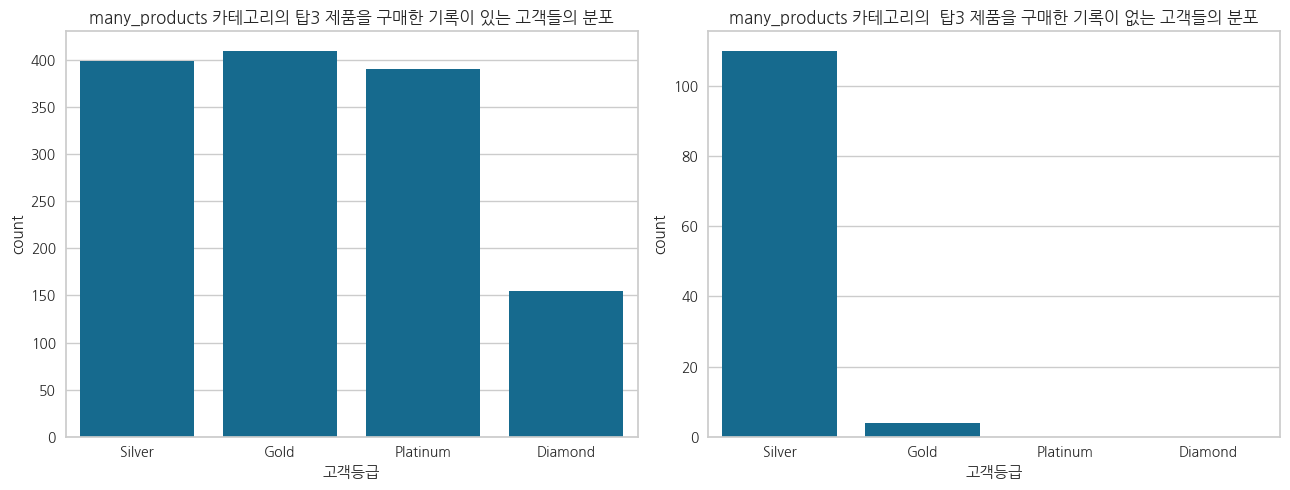

In [ ]:
plt.figure(figsize=(13,5))

plt.subplot(1,2,1)
plt.title("many_products 카테고리의 탑3 제품을 구매한 기록이 있는 고객들의 분포")
sns.countplot(data=high_user2, x="고객등급", order=grade_order)

plt.subplot(1,2,2)
plt.title("many_products 카테고리의  탑3 제품을 구매한 기록이 없는 고객들의 분포")
sns.countplot(data=not_high_user2, x="고객등급", order=grade_order)

plt.tight_layout()

many_products는 탑3안에 들어있는 제품들을 추천하면 좋을거같다.

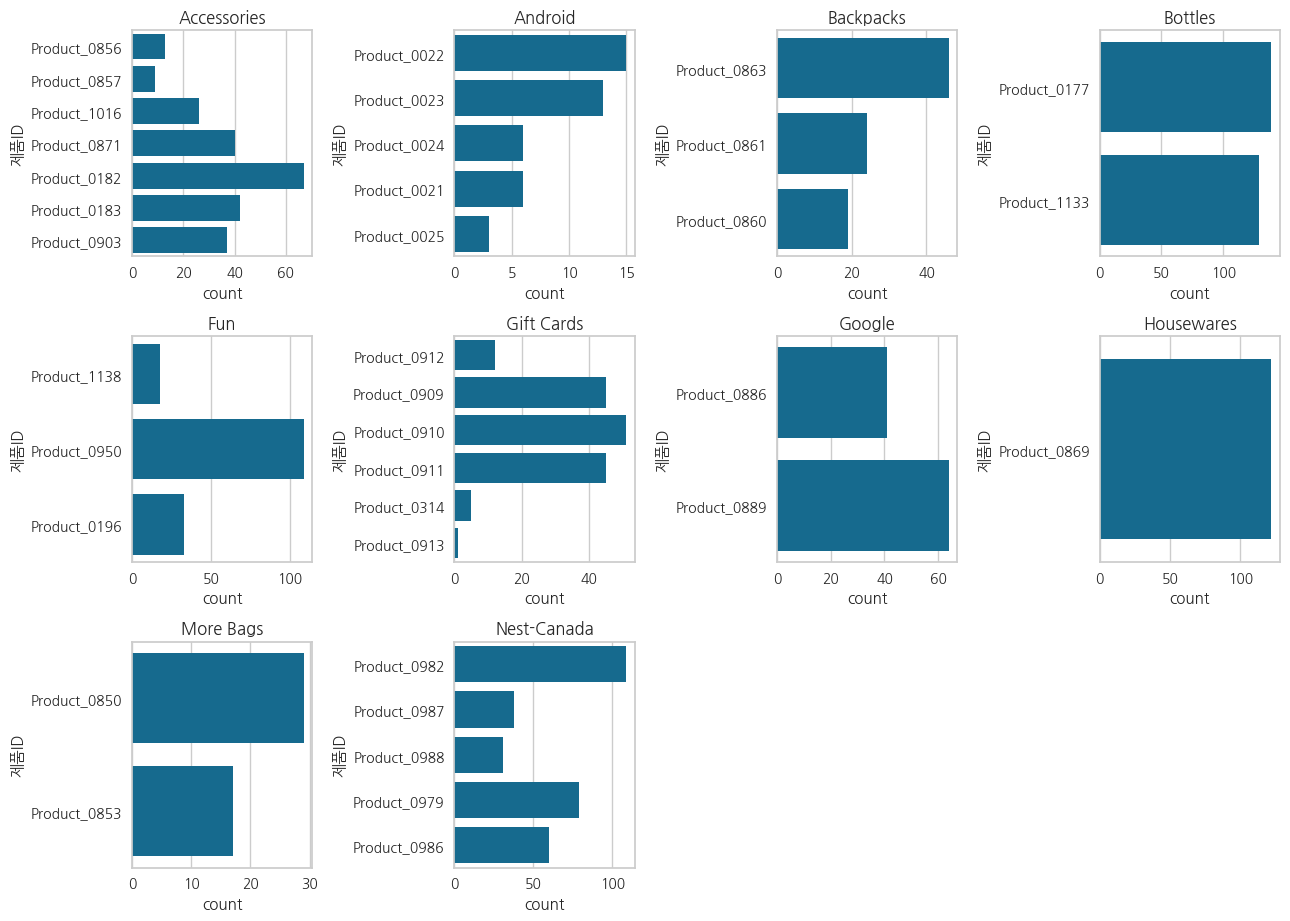

In [ ]:
plt.figure(figsize=(13,15))

for i,columns in enumerate(little_products):
  dat = dat_raw[dat_raw["제품카테고리"] == columns]
  plt.subplot(5,4,i+1)
  plt.title(columns)
  sns.countplot(data=dat, y="제품ID")

plt.tight_layout()

제품수가 너무 많지않아서, 상위몇개의 제품을 샀을때? 이런 분석이 어려워보인다. 다른 방법으로 little_products를 추천할 수 있는 방법을 찾아보자

<Axes: xlabel='카테고리수', ylabel='count'>

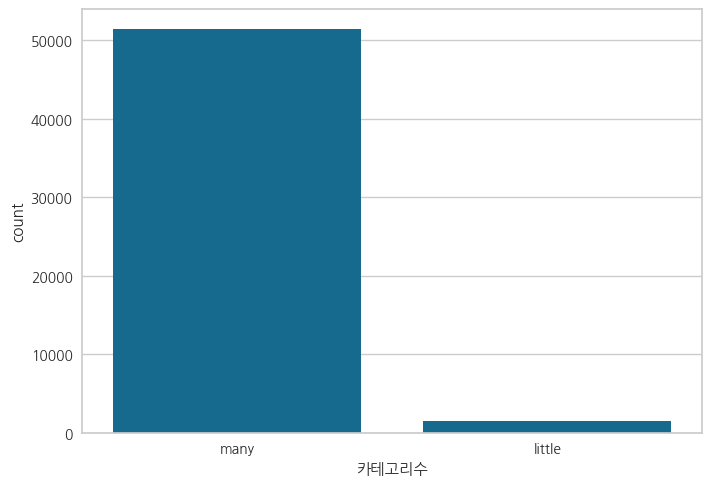

In [ ]:
sns.countplot(data=dat_raw, x="카테고리수")

### 등급별 제품선호도

실버

<Axes: xlabel='count', ylabel='제품카테고리'>

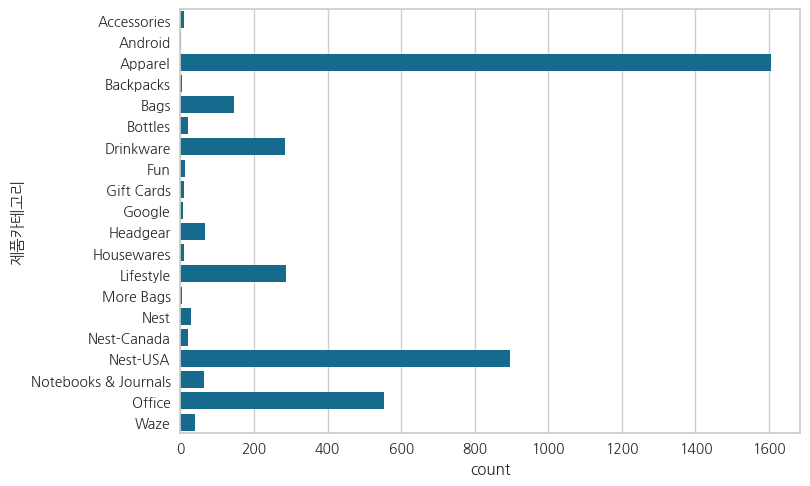

In [ ]:
sns.countplot(Silver, y="제품카테고리", order=category_order)

In [ ]:
category_cross_selling_user(Silver)[:14]

,antecedents,consequents,support,confidence,leverage,conviction,zhangs_metric,lift
22,"(Office, Apparel)",(Drinkware),0.212181,0.500000,0.058777,1.277014,0.481229,1.383152
27,(Drinkware),"(Office, Apparel)",0.212181,0.586957,0.058777,1.393651,0.433846,1.383152
24,"(Apparel, Drinkware)",(Office),0.212181,0.705882,0.058047,1.656582,0.391152,1.376606
25,(Office),"(Apparel, Drinkware)",0.212181,0.413793,0.058047,1.193112,0.561492,1.376606
12,(Office),(Lifestyle),0.216110,0.421456,0.058955,1.198728,0.559897,1.375135
13,(Lifestyle),(Office),0.216110,0.705128,0.058955,1.652345,0.393356,1.375135
11,(Drinkware),(Office),0.241650,0.668478,0.056287,1.469677,0.364803,1.303661
10,(Office),(Drinkware),0.241650,0.471264,0.056287,1.207611,0.478068,1.303661
30,"(Apparel, Nest-USA)",(Office),0.308448,0.615686,0.051559,1.267792,0.334972,1.200706
31,(Office),"(Apparel, Nest-USA)",0.308448,0.601533,0.051559,1.252342,0.343076,1.200706


In [ ]:
category_cross_selling_transaction(Silver)[:14]

,antecedents,consequents,support,confidence,leverage,conviction,zhangs_metric,lift
36,"(Office, Lifestyle)",(Bags),0.011923,0.310811,0.009517,1.359965,0.830025,4.954992
37,(Bags),"(Office, Lifestyle)",0.011923,0.190083,0.009517,1.187329,0.851602,4.954992
30,"(Office, Drinkware)",(Bags),0.013478,0.309524,0.010747,1.357430,0.833646,4.934475
31,(Bags),"(Office, Drinkware)",0.013478,0.214876,0.010747,1.218221,0.850706,4.934475
34,"(Bags, Office)",(Lifestyle),0.011923,0.425926,0.009485,1.590227,0.818435,4.890542
39,(Lifestyle),"(Bags, Office)",0.011923,0.136905,0.009485,1.126187,0.871417,4.890542
28,"(Bags, Office)",(Drinkware),0.013478,0.481481,0.010402,1.716619,0.793969,4.381027
33,(Drinkware),"(Bags, Office)",0.013478,0.122642,0.010402,1.107878,0.867031,4.381027
35,"(Bags, Lifestyle)",(Office),0.011923,0.741935,0.009199,3.218118,0.784121,4.376739
38,(Office),"(Bags, Lifestyle)",0.011923,0.070336,0.009199,1.058372,0.929002,4.376739


골드

<Axes: xlabel='count', ylabel='제품카테고리'>

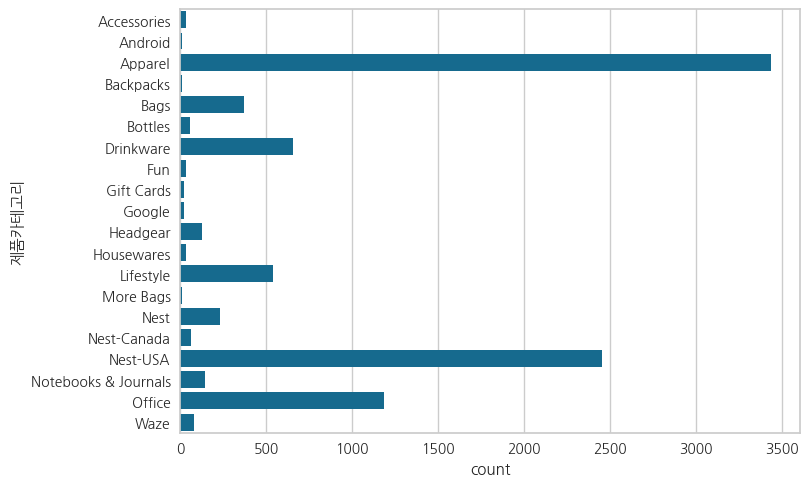

In [ ]:
sns.countplot(Gold, y="제품카테고리", order=category_order)

In [ ]:
category_cross_selling_user(Gold)[:14]

,antecedents,consequents,support,confidence,leverage,conviction,zhangs_metric,lift
646,"(Bags, Office, Nest-USA)","(Apparel, Drinkware, Lifestyle)",0.263285,0.619318,0.090772,1.560891,0.599722,1.526177
639,"(Apparel, Drinkware, Lifestyle)","(Bags, Office, Nest-USA)",0.263285,0.648810,0.090772,1.636944,0.580219,1.526177
621,"(Bags, Office, Apparel, Nest-USA)","(Drinkware, Lifestyle)",0.263285,0.622857,0.090731,1.569133,0.596944,1.525816
664,"(Drinkware, Lifestyle)","(Bags, Office, Apparel, Nest-USA)",0.263285,0.644970,0.090731,1.626047,0.582325,1.525816
590,"(Bags, Office, Nest-USA)","(Drinkware, Lifestyle)",0.263285,0.619318,0.089745,1.554546,0.592938,1.517146
603,"(Drinkware, Lifestyle)","(Bags, Office, Nest-USA)",0.263285,0.644970,0.089745,1.619243,0.575997,1.517146
471,"(Apparel, Drinkware, Lifestyle)","(Bags, Office)",0.270531,0.666667,0.092138,1.681159,0.573171,1.516484
482,"(Bags, Office)","(Apparel, Drinkware, Lifestyle)",0.270531,0.615385,0.092138,1.544928,0.607759,1.516484
468,"(Bags, Office, Apparel)","(Drinkware, Lifestyle)",0.270531,0.618785,0.092062,1.552370,0.604652,1.515839
485,"(Drinkware, Lifestyle)","(Bags, Office, Apparel)",0.270531,0.662722,0.092062,1.668658,0.575036,1.515839


In [ ]:
category_cross_selling_transaction(Gold)[:14]

,antecedents,consequents,support,confidence,leverage,conviction,zhangs_metric,lift
39,(Lifestyle),"(Bags, Office)",0.010006,0.153595,0.008411,1.152540,0.899175,6.273345
34,"(Bags, Office)",(Lifestyle),0.010006,0.408696,0.008411,1.581000,0.861693,6.273345
28,"(Bags, Office)",(Drinkware),0.013413,0.547826,0.010906,1.985064,0.833475,5.349562
33,(Drinkware),"(Bags, Office)",0.013413,0.130977,0.010906,1.122544,0.905831,5.349562
36,"(Office, Lifestyle)",(Bags),0.010006,0.317568,0.007980,1.371130,0.823482,4.939122
37,(Bags),"(Office, Lifestyle)",0.010006,0.155629,0.007980,1.146997,0.852337,4.939122
35,"(Bags, Lifestyle)",(Office),0.010006,0.661972,0.007815,2.529416,0.792965,4.565759
38,(Office),"(Bags, Lifestyle)",0.010006,0.069016,0.007815,1.057896,0.913410,4.565759
30,"(Office, Drinkware)",(Bags),0.013413,0.291667,0.010456,1.320993,0.817133,4.536286
31,(Bags),"(Office, Drinkware)",0.013413,0.208609,0.010456,1.205489,0.833122,4.536286


플레티넘

<Axes: xlabel='count', ylabel='제품카테고리'>

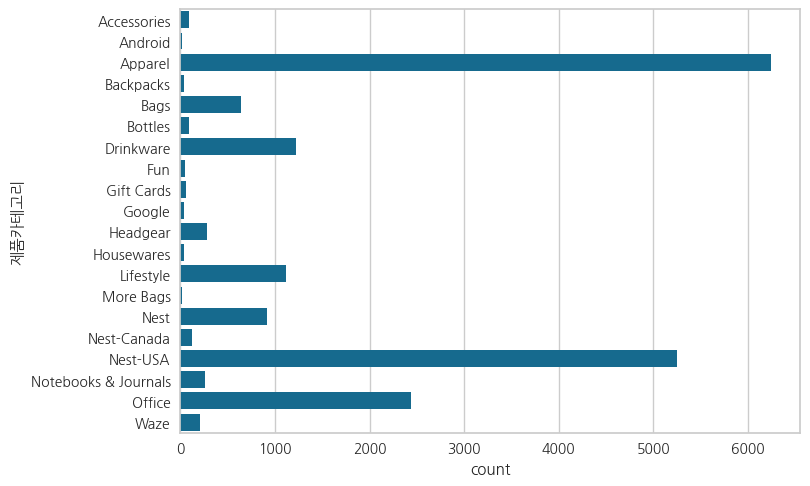

In [ ]:
sns.countplot(Platinum, y="제품카테고리", order=category_order)

In [ ]:
category_cross_selling_user(Platinum)[:14]

,antecedents,consequents,support,confidence,leverage,conviction,zhangs_metric,lift
2931,"(Bags, Drinkware, Lifestyle)","(Office, Notebooks & Journals)",0.251282,0.473430,0.075720,1.270924,0.642188,1.431300
2938,"(Office, Notebooks & Journals)","(Bags, Drinkware, Lifestyle)",0.251282,0.759690,0.075720,1.952605,0.450270,1.431300
3716,"(Bags, Apparel, Drinkware, Lifestyle)","(Office, Notebooks & Journals)",0.251282,0.473430,0.075720,1.270924,0.642188,1.431300
3728,"(Office, Apparel, Notebooks & Journals)","(Bags, Drinkware, Lifestyle)",0.251282,0.759690,0.075720,1.952605,0.450270,1.431300
3741,"(Bags, Drinkware, Lifestyle)","(Office, Apparel, Notebooks & Journals)",0.251282,0.473430,0.075720,1.270924,0.642188,1.431300
3753,"(Office, Notebooks & Journals)","(Bags, Apparel, Drinkware, Lifestyle)",0.251282,0.759690,0.075720,1.952605,0.450270,1.431300
4537,"(Bags, Drinkware, Lifestyle)","(Office, Notebooks & Journals, Nest-USA)",0.248718,0.468599,0.074517,1.264196,0.638499,1.427763
4891,"(Bags, Apparel, Drinkware, Lifestyle)","(Office, Notebooks & Journals, Nest-USA)",0.248718,0.468599,0.074517,1.264196,0.638499,1.427763
4941,"(Bags, Drinkware, Lifestyle)","(Office, Apparel, Notebooks & Journals, Nest-USA)",0.248718,0.468599,0.074517,1.264196,0.638499,1.427763
4530,"(Office, Notebooks & Journals, Nest-USA)","(Bags, Drinkware, Lifestyle)",0.248718,0.757812,0.074517,1.937469,0.445975,1.427763


In [ ]:
product_cross_selling_user(Platinum)[:14]

,antecedents,consequents,support,confidence,leverage,conviction,zhangs_metric,lift
84,(Product_0917),(Product_0918),0.205128,0.683761,0.119744,2.262162,0.833929,2.402402
85,(Product_0918),(Product_0917),0.205128,0.720721,0.119744,2.506452,0.815995,2.402402
430,"(Product_0983, Product_0917)",(Product_0915),0.207692,0.757009,0.114832,2.722485,0.761942,2.236619
431,(Product_0915),"(Product_0983, Product_0917)",0.207692,0.613636,0.114832,1.878130,0.835774,2.236619
60,(Product_0915),(Product_0917),0.225641,0.666667,0.124103,2.100000,0.831395,2.222222
61,(Product_0917),(Product_0915),0.225641,0.752137,0.124103,2.668966,0.785714,2.222222
423,"(Product_0915, Product_0981)",(Product_0917),0.212821,0.664000,0.116667,2.083333,0.806774,2.213333
426,(Product_0917),"(Product_0915, Product_0981)",0.212821,0.709402,0.116667,2.338235,0.783133,2.213333
424,"(Product_0917, Product_0981)",(Product_0915),0.212821,0.747748,0.116489,2.622527,0.765125,2.209255
425,(Product_0915),"(Product_0917, Product_0981)",0.212821,0.628788,0.116489,1.927159,0.827403,2.209255


In [ ]:
category_cross_selling_transaction(Platinum)[:14]

,antecedents,consequents,support,confidence,leverage,conviction,zhangs_metric,lift
51,(Drinkware),"(Bags, Office)",0.013062,0.139665,0.010882,1.135253,0.919115,5.993687
46,"(Bags, Office)",(Drinkware),0.013062,0.560538,0.010882,2.062701,0.853035,5.993687
48,"(Office, Drinkware)",(Bags),0.013062,0.314861,0.010743,1.377964,0.858044,5.632195
49,(Bags),"(Office, Drinkware)",0.013062,0.233645,0.010743,1.250747,0.871150,5.632195
52,"(Office, Drinkware)",(Lifestyle),0.014629,0.352645,0.011807,1.439666,0.842031,5.184042
57,(Lifestyle),"(Office, Drinkware)",0.014629,0.215054,0.011807,1.221123,0.866011,5.184042
47,"(Bags, Drinkware)",(Office),0.013062,0.664894,0.010274,2.560674,0.802342,4.685591
50,(Office),"(Bags, Drinkware)",0.013062,0.092047,0.010274,1.079742,0.916655,4.685591
53,"(Office, Lifestyle)",(Drinkware),0.014629,0.433437,0.011473,1.599959,0.811626,4.634623
56,(Drinkware),"(Office, Lifestyle)",0.014629,0.156425,0.011473,1.145421,0.865142,4.634623


다이아몬드

<Axes: xlabel='count', ylabel='제품카테고리'>

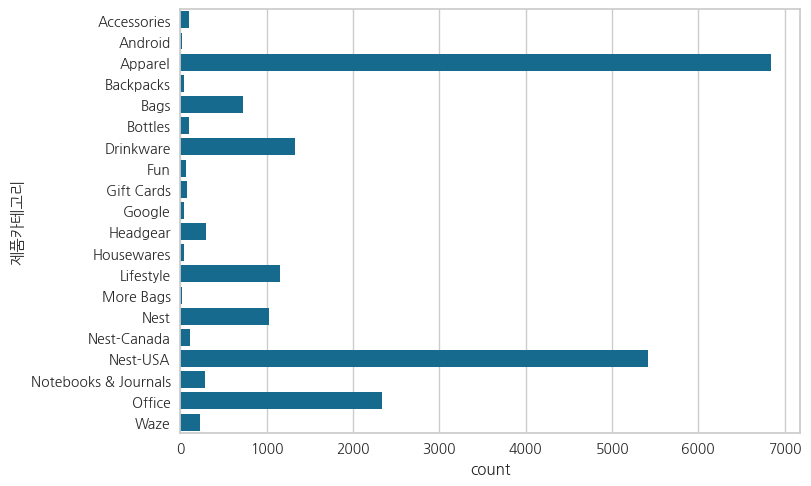

In [ ]:
sns.countplot(Diamond, y="제품카테고리", order=category_order)

In [ ]:
category_cross_selling_user(Diamond)[:14]

,antecedents,consequents,support,confidence,leverage,conviction,zhangs_metric,lift
106659,"(Waze, Headgear, Office, Bags, Lifestyle)","(Nest-Canada, Notebooks & Journals)",0.206452,0.524590,0.094735,1.506340,0.756649,1.847988
106758,"(Nest-Canada, Notebooks & Journals)","(Waze, Headgear, Office, Bags, Lifestyle)",0.206452,0.727273,0.094735,2.223656,0.640766,1.847988
129159,"(Waze, Apparel, Headgear, Office, Bags, Lifest...","(Nest-Canada, Notebooks & Journals)",0.206452,0.524590,0.094735,1.506340,0.756649,1.847988
129207,"(Waze, Headgear, Office, Bags, Lifestyle)","(Nest-Canada, Apparel, Notebooks & Journals)",0.206452,0.524590,0.094735,1.506340,0.756649,1.847988
129322,"(Nest-Canada, Apparel, Notebooks & Journals)","(Waze, Headgear, Office, Bags, Lifestyle)",0.206452,0.727273,0.094735,2.223656,0.640766,1.847988
129370,"(Nest-Canada, Notebooks & Journals)","(Waze, Apparel, Headgear, Office, Bags, Lifest...",0.206452,0.727273,0.094735,2.223656,0.640766,1.847988
138677,"(Waze, Headgear, Office, Drinkware, Bags, Life...","(Nest-Canada, Notebooks & Journals)",0.206452,0.524590,0.094735,1.506340,0.756649,1.847988
138715,"(Waze, Headgear, Office, Bags, Lifestyle)","(Nest-Canada, Drinkware, Notebooks & Journals)",0.206452,0.524590,0.094735,1.506340,0.756649,1.847988
138838,"(Nest-Canada, Drinkware, Notebooks & Journals)","(Waze, Headgear, Office, Bags, Lifestyle)",0.206452,0.727273,0.094735,2.223656,0.640766,1.847988
138876,"(Nest-Canada, Notebooks & Journals)","(Waze, Headgear, Office, Drinkware, Bags, Life...",0.206452,0.727273,0.094735,2.223656,0.640766,1.847988


In [ ]:
product_cross_selling_user(Diamond)[:14]

,antecedents,consequents,support,confidence,leverage,conviction,zhangs_metric,lift
2633756,"(Product_0990, Product_0994, Product_0918, Pro...","(Product_0992, Product_0917)",0.2,0.939394,0.138189,11.709677,0.877842,3.23569
2633789,"(Product_0992, Product_0917)","(Product_0990, Product_0994, Product_0918, Pro...",0.2,0.688889,0.138189,2.529954,0.973607,3.23569
5245980,"(Product_0994, Product_0918, Product_0990, Pro...","(Product_0992, Product_0917)",0.2,0.939394,0.138189,11.709677,0.877842,3.23569
5246001,"(Product_0990, Product_0994, Product_0918, Pro...","(Product_0992, Product_0917, Product_0976)",0.2,0.939394,0.138189,11.709677,0.877842,3.23569
5246044,"(Product_0992, Product_0917, Product_0976)","(Product_0990, Product_0994, Product_0918, Pro...",0.2,0.688889,0.138189,2.529954,0.973607,3.23569
5246065,"(Product_0992, Product_0917)","(Product_0994, Product_0918, Product_0990, Pro...",0.2,0.688889,0.138189,2.529954,0.973607,3.23569
5250631,"(Product_0994, Product_0981, Product_0918, Pro...","(Product_0992, Product_0917)",0.2,0.939394,0.138189,11.709677,0.877842,3.23569
5250658,"(Product_0990, Product_0994, Product_0918, Pro...","(Product_0992, Product_0917, Product_0981)",0.2,0.939394,0.138189,11.709677,0.877842,3.23569
5250691,"(Product_0992, Product_0917, Product_0981)","(Product_0990, Product_0994, Product_0918, Pro...",0.2,0.688889,0.138189,2.529954,0.973607,3.23569
5250718,"(Product_0992, Product_0917)","(Product_0994, Product_0981, Product_0918, Pro...",0.2,0.688889,0.138189,2.529954,0.973607,3.23569


In [ ]:
category_cross_selling_transaction(Diamond)[:14]

,antecedents,consequents,support,confidence,leverage,conviction,zhangs_metric,lift
54,"(Office, Drinkware)",(Lifestyle),0.015402,0.368675,0.012601,1.477776,0.853822,5.499121
59,(Lifestyle),"(Office, Drinkware)",0.015402,0.229730,0.012601,1.244010,0.876945,5.499121
48,"(Bags, Office)",(Drinkware),0.011476,0.495652,0.009187,1.786758,0.819535,5.014062
53,(Drinkware),"(Bags, Office)",0.011476,0.116090,0.009187,1.105143,0.888379,5.014062
55,"(Office, Lifestyle)",(Drinkware),0.015402,0.473684,0.012188,1.712180,0.817905,4.791832
58,(Drinkware),"(Office, Lifestyle)",0.015402,0.155804,0.012188,1.146044,0.878115,4.791832
30,"(Apparel, Drinkware)",(Lifestyle),0.013590,0.318396,0.010728,1.368768,0.824634,4.749171
35,(Lifestyle),"(Apparel, Drinkware)",0.013590,0.202703,0.010728,1.200704,0.846166,4.749171
50,"(Office, Drinkware)",(Bags),0.011476,0.274699,0.008923,1.294492,0.811462,4.495647
51,(Bags),"(Office, Drinkware)",0.011476,0.187809,0.008923,1.179801,0.828166,4.495647


일단 다양한 제품과 다양한 카테고리를 추천해주는 것이 등급과 관련이 있다!

결론 :

실버,골드 그룹은 거래와, 고객에 대한 카테고리 연관검색으로, 연관된 카테고리의 top3 제품을 추천해주는 방향

플레티넘,다이아 그룹은 거래와, 고객에 대한 카테고리 연관검색으로 연관된 카테고리의 top3제품을 추천하고, 고객에 대한 상품연관검색도 시행해서 추천해준다.
왜냐하면, 데이터가많고, 재구매율도 높기때문에 상품들에 대한 연관검색도 실행할 수 있다. -> 그리고 유지에 더 도움이 될거같다.

###평균금액별 등급분포(의미있는 인사이트 발견하지 못함)

In [ ]:
dat_raw[dat_raw["제품ID"] == "Product_0981"][["제품카테고리", "평균금액"]].value_counts()

제품카테고리    평균금액  
Nest-USA  149.00    2515
          153.71     579
          151.88     384
          249.00      25
          256.88       7
          19.19        1
dtype: int64

In [ ]:
# df_on[df_on["제품ID"] == "Product_0981"][["제품카테고리", "수량"]].value_counts()

제품카테고리    수량
Nest-USA  1     2728
          2      615
          3       93
          4       43
          5       31
          6        1
dtype: int64

평균금액이 다르다..?, 배송료나 수량은 그렇게 큰 차이를 볼 순 없었다.?

In [ ]:
# dat_raw[dat_raw["제품ID"] == "Product_0992"][["제품카테고리", "평균금액", "고객등급"]].sort_values(by="평균금액", ascending=False).value_counts()

dat_raw[dat_raw["제품ID"] == "Product_0981"].groupby(["평균금액","고객등급"]).agg({"거래ID":"count"})

거래ID
평균금액   고객등급          
19.19  Gold         1
149.00 Diamond    976
       Gold       428
       Platinum   976
       Silver     135
151.88 Diamond    214
       Gold        35
       Platinum   126
       Silver       9
153.71 Diamond    157
       Gold       135
       Platinum   209
       Silver      78
249.00 Diamond      3
       Gold         4
       Platinum    17
       Silver       1
256.88 Diamond      4
       Gold         1
       Platinum     1
       Silver       1

확인해본결과, 같은 제품마다 가격이 다른데, 그중에서도 가격이 가장 저렴할때 다이아,플래가 좀 많이사고, 가격이 커질수록 실버나 골드의 비중이 생긴다.
-> 다이아나 플레티넘은 이 물건이 가장 쌀때가 언제인지 알고있다.
-> 마케팅의 힘일까? 아니면 너무 많이 사용해서 빠삭해진걸까

-> 근데 이건 상위 8개의 제품만 확인한결과이므로 단정짓기는 어렵다.
-> 더 확인을 해봐야할 필요성을 느낀다.

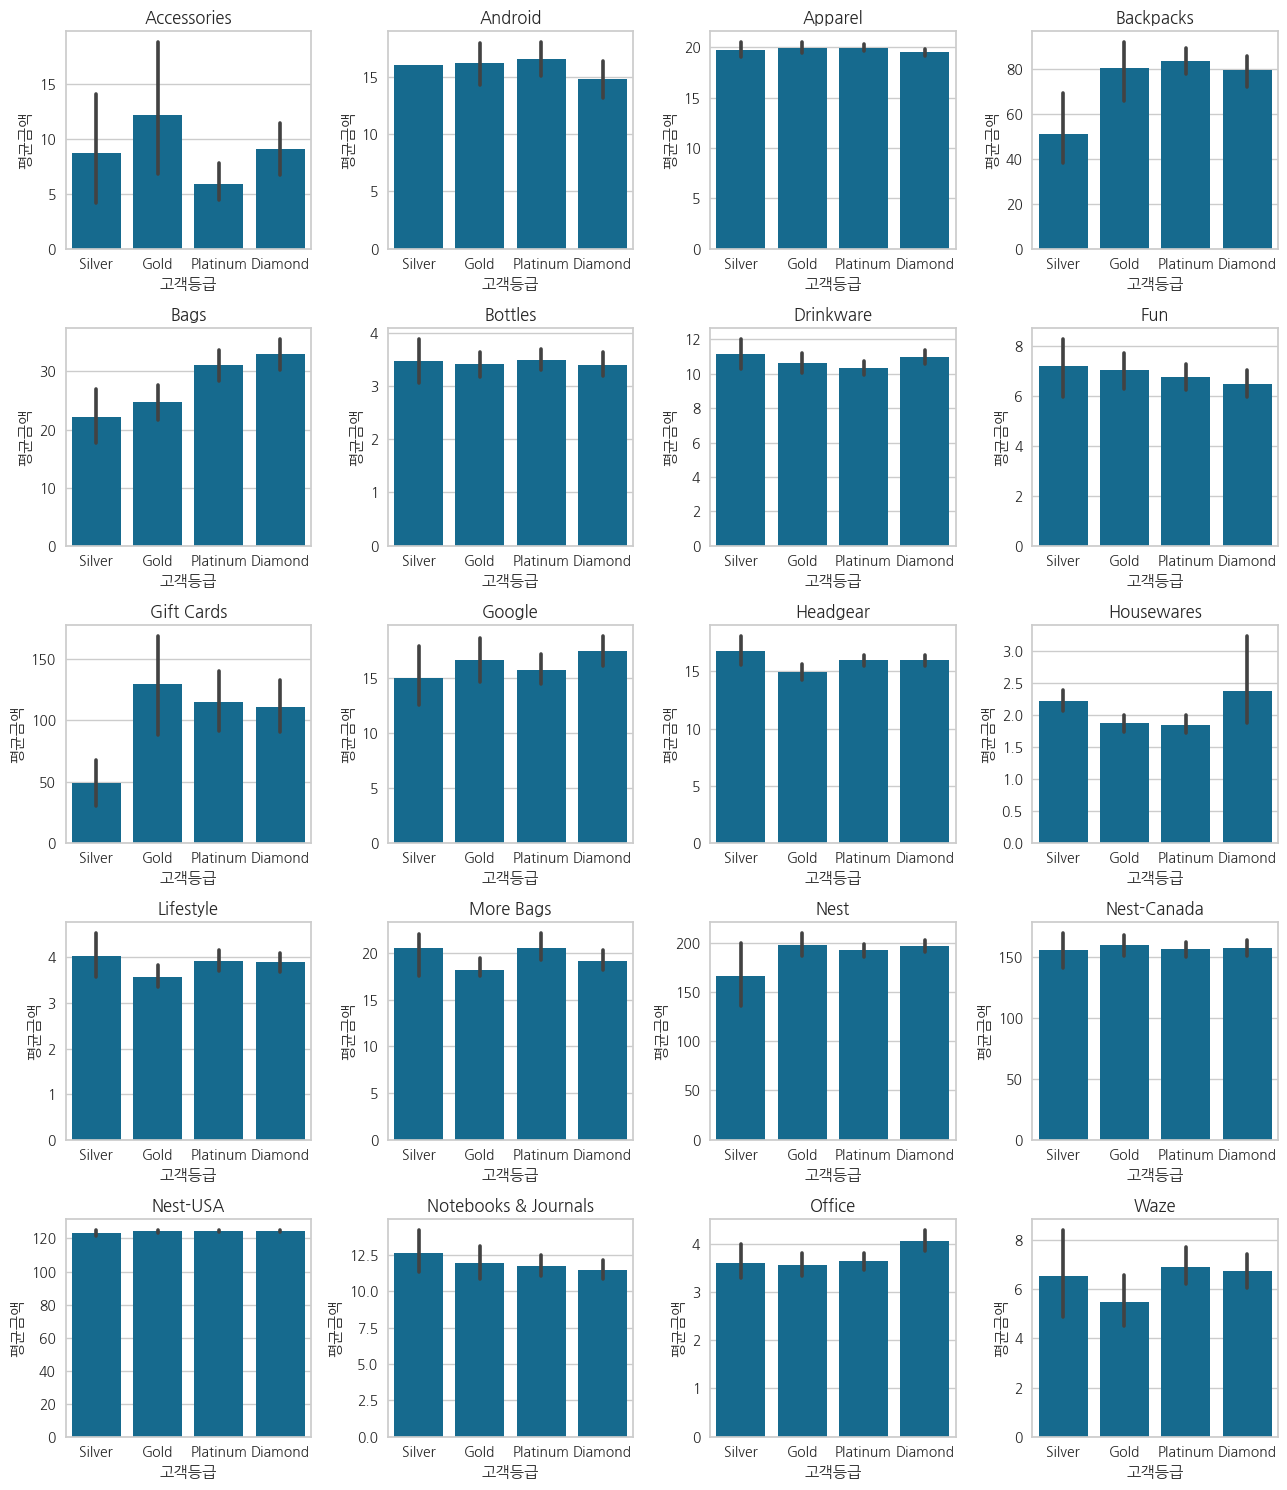

In [ ]:
plt.figure(figsize=(13,15))

for i,columns in enumerate(category_order):
  dat = dat_raw[dat_raw["제품카테고리"] == columns]
  plt.subplot(5,4,i+1)
  plt.title(columns)
  sns.barplot(data=dat, x="고객등급", y="평균금액", order=grade_order)

plt.tight_layout()

음.. 제품별 평균금액의 평균값을 내봤는데 생각보다 다 비슷하다. 아닌것도 있지만,이게 큰 차이를 가져오지는 않는거같다.

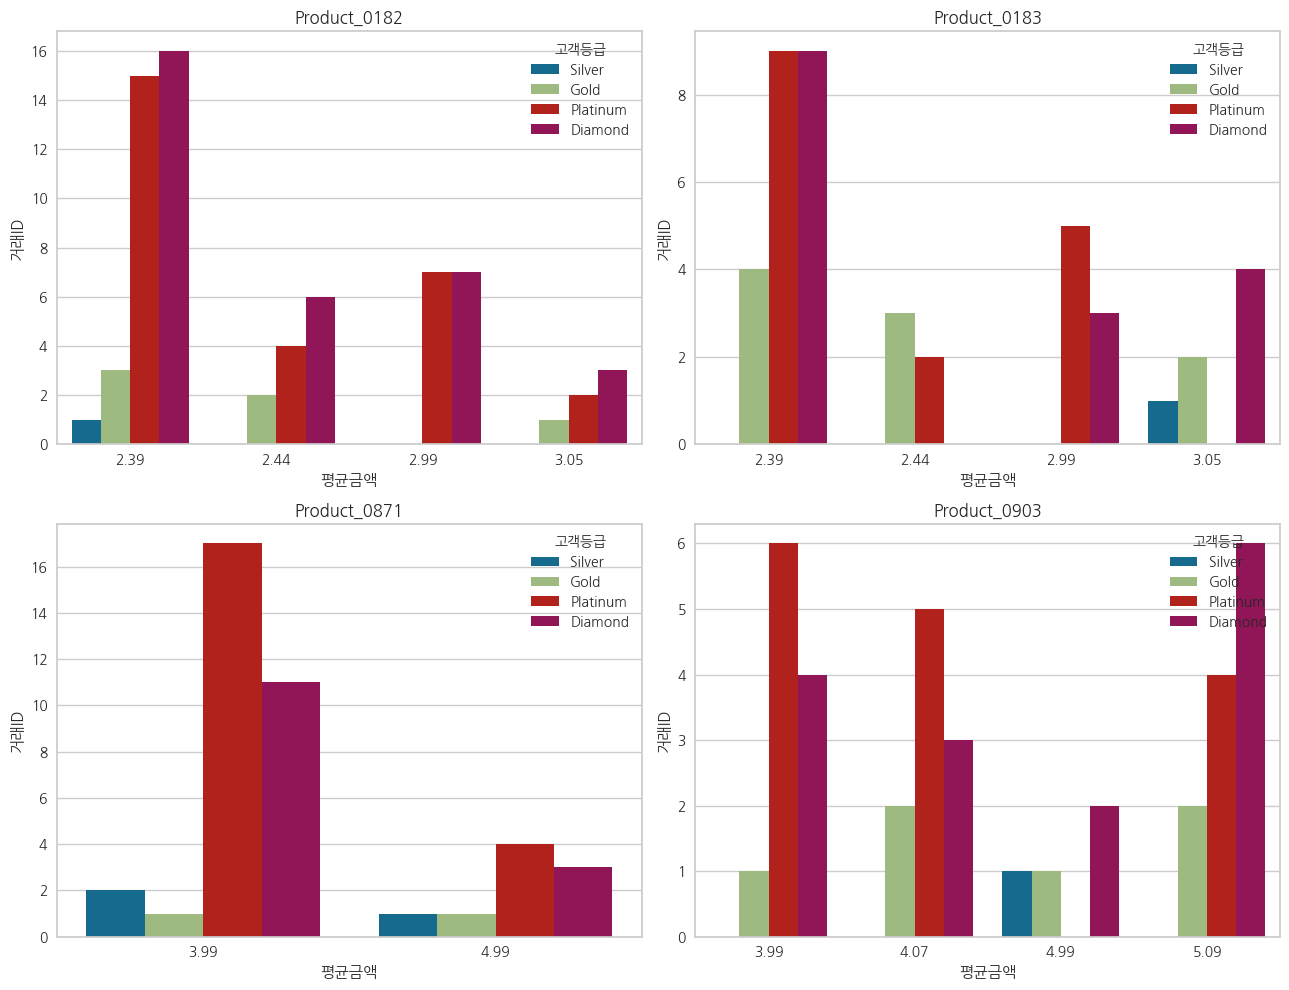

In [ ]:
# ['Accessories','Android', 'Apparel', 'Bags', 'Bottles', 'Drinkware', 'Fun', 'Gift Cards', 'Google', 'Headgear',
#  'Housewares', 'Lifestyle', 'More Bags', 'Nest', 'Nest-Canada', 'Nest-USA','Notebooks & Journals', 'Office', 'Waze']


# 상위 4개 제품에 대한 등급별 평균금액 비교

test= dat_raw[dat_raw["제품카테고리"] == "Accessories"]
product_test = test.groupby("제품ID")["거래ID"].count().sort_values(ascending=False).index[:4]

plt.figure(figsize=(13,10))

for i,product in enumerate(product_test):
  pro = test[test["제품ID"] == product].groupby(["평균금액","고객등급"]).agg({"거래ID":"count"}).reset_index()
  plt.subplot(2,2,i+1)
  plt.title(product)
  sns.barplot(data=pro, x="평균금액", y="거래ID", hue="고객등급", hue_order=grade_order)

plt.tight_layout()

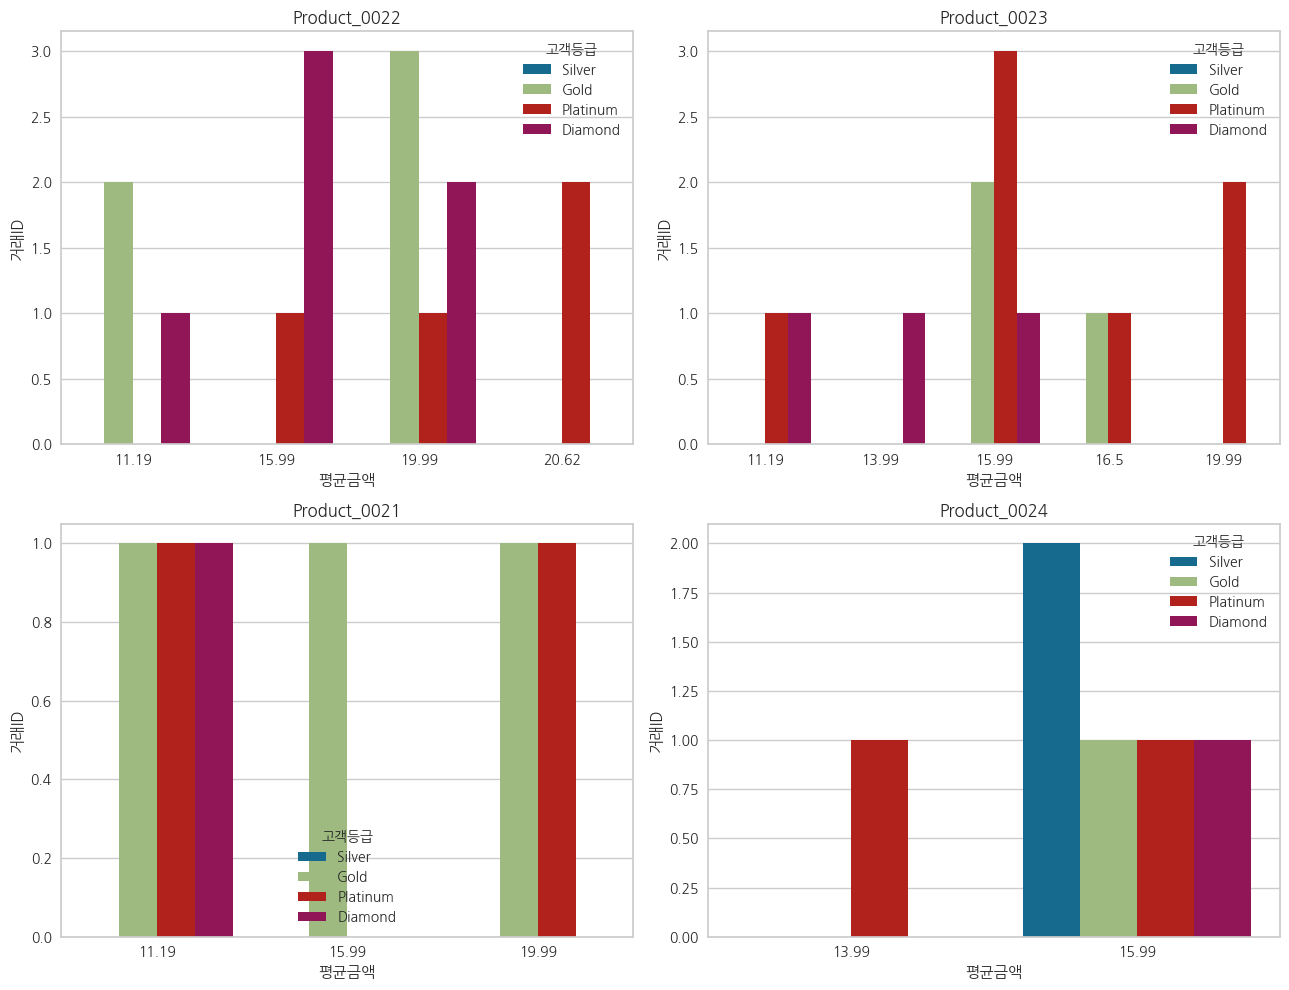

In [ ]:
# ['Accessories','Android', 'Apparel', 'Bags', 'Bottles', 'Drinkware', 'Fun', 'Gift Cards', 'Google', 'Headgear',
#  'Housewares', 'Lifestyle', 'More Bags', 'Nest', 'Nest-Canada', 'Nest-USA','Notebooks & Journals', 'Office', 'Waze']

# 상위 4개 제품에 대한 등급별 평균금액 비교

test= dat_raw[dat_raw["제품카테고리"] == "Android"]
product_test = test.groupby("제품ID")["거래ID"].count().sort_values(ascending=False).index[:4]

plt.figure(figsize=(13,10))

for i,product in enumerate(product_test):
  pro = test[test["제품ID"] == product].groupby(["평균금액","고객등급"]).agg({"거래ID":"count"}).reset_index()
  plt.subplot(2,2,i+1)
  plt.title(product)
  sns.barplot(data=pro, x="평균금액", y="거래ID", hue="고객등급", hue_order=grade_order)

plt.tight_layout()

확인결과 평균금액별 등급의 차이로 인사이트를 도출하지 못했다.

### 쿠폰사용유무에 따른 분석

little_products,many_products는 상위제품 구매 고객분석에서 만든 친구들이다.

In [ ]:
little_products_df = dat_raw[(dat_raw["쿠폰상태"] == "Used") & (dat_raw["제품카테고리"].isin(little_products))].copy()
many_products_df = dat_raw[(dat_raw["쿠폰상태"] == "Used") & (dat_raw["제품카테고리"].isin(many_products))].copy()

일단 두 그룹의 쿠폰분포를 확인해봤는데, used, not_used, cliked는 비슷하다..

In [ ]:
little_products_df_low = little_products_df[(little_products_df["고객등급"] == "Silver") | (little_products_df["고객등급"] == "Gold")].copy()
little_products_df_high = little_products_df[(little_products_df["고객등급"] == "Platinum") | (little_products_df["고객등급"] == "Diamond")].copy()

many_products_df_low = many_products_df[(many_products_df["고객등급"] == "Silver") | (many_products_df["고객등급"] == "Gold")].copy()
many_products_df_high = many_products_df[(many_products_df["고객등급"] == "Platinum") | (many_products_df["고객등급"] == "Diamond")].copy()

In [ ]:
little_products_df_low.groupby(["제품카테고리"])["할인율"].value_counts(normalize=True).unstack(fill_value=0) * 100

할인율,0.0,10.0,20.0,30.0
제품카테고리,,,,
Accessories,0.0,28.571429,42.857143,28.571429
Android,0.0,33.333333,33.333333,33.333333
Backpacks,100.0,0.000000,0.000000,0.000000
Bottles,0.0,47.826087,26.086957,26.086957
Fun,100.0,0.000000,0.000000,0.000000
Gift Cards,0.0,62.500000,25.000000,12.500000
Google,100.0,0.000000,0.000000,0.000000
Housewares,0.0,23.076923,30.769231,46.153846
More Bags,100.0,0.000000,0.000000,0.000000


In [ ]:
little_products_df_high.groupby(["제품카테고리"])["할인율"].value_counts(normalize=True).unstack(fill_value=0) * 100

할인율,0.0,10.0,20.0,30.0
제품카테고리,,,,
Accessories,0.0,25.396825,46.031746,28.571429
Android,0.0,42.857143,28.571429,28.571429
Backpacks,100.0,0.000000,0.000000,0.000000
Bottles,0.0,37.288136,32.203390,30.508475
Fun,100.0,0.000000,0.000000,0.000000
Gift Cards,0.0,62.500000,18.750000,18.750000
Google,100.0,0.000000,0.000000,0.000000
Housewares,0.0,26.086957,43.478261,30.434783
More Bags,100.0,0.000000,0.000000,0.000000


둘다 10~20퍼쪽에서 많이 쓴듯

In [ ]:
many_products_df_low.groupby(["제품카테고리"])["할인율"].value_counts(normalize=True).unstack(fill_value=0) * 100

할인율,10.0,20.0,30.0
제품카테고리,,,
Apparel,31.877214,34.769776,33.353011
Bags,31.515152,29.696970,38.787879
Drinkware,33.670034,28.619529,37.710438
Headgear,33.823529,29.411765,36.764706
Lifestyle,32.055749,31.707317,36.236934
Nest,23.157895,26.315789,50.526316
Nest-USA,36.752899,25.869759,37.377342
Notebooks & Journals,23.437500,34.375000,42.187500
Office,33.388158,30.921053,35.690789


In [ ]:
many_products_df_high.groupby(["제품카테고리"])["할인율"].value_counts(normalize=True).unstack(fill_value=0) * 100

할인율,10.0,20.0,30.0
제품카테고리,,,
Apparel,32.384581,34.872255,32.743165
Bags,36.521739,31.739130,31.739130
Drinkware,34.490741,35.532407,29.976852
Headgear,37.234043,31.382979,31.382979
Lifestyle,37.837838,34.643735,27.518428
Nest,19.040000,35.840000,45.120000
Nest-USA,34.252297,33.918129,31.829574
Notebooks & Journals,38.341969,44.041451,17.616580
Office,34.470158,35.688185,29.841657


In [ ]:
# '제품카테고리' 열에 속하는 카테고리가 little_products인지 확인하고, '카테고리수' 열에 'little' 할당
dat_raw.loc[dat_raw["제품카테고리"].isin(little_products), '카테고리수'] = 'little'

# '제품카테고리' 열에 속하는 카테고리가 many_products인지 확인하고, '카테고리수' 열에 'many' 할당
dat_raw.loc[dat_raw["제품카테고리"].isin(many_products), '카테고리수'] = 'many'

In [ ]:
dat_raw.head()

,고객ID,거래ID,거래날짜,제품ID,제품카테고리,수량,평균금액,배송료,쿠폰상태,성별,...,할인금액,거래금액,계절,최소거래월,최대거래월,고객수명,오프라인비용,온라인비용,고객등급,카테고리수
0,USER_1358,Transaction_0000,2019-01-01,Product_0981,Nest-USA,1,153.71,6.50,Used,남,...,16.9081,158.6729,겨울,1,1,1,4500,2424.5,Diamond,many
1,USER_1358,Transaction_0001,2019-01-01,Product_0981,Nest-USA,1,153.71,6.50,Used,남,...,16.9081,158.6729,겨울,1,1,1,4500,2424.5,Diamond,many
2,USER_1358,Transaction_0002,2019-01-01,Product_0904,Office,1,2.05,6.50,Used,남,...,0.2255,8.5295,겨울,1,1,1,4500,2424.5,Diamond,many
3,USER_1358,Transaction_0003,2019-01-01,Product_0203,Apparel,5,17.53,0.06,Not Used,남,...,0.0000,103.4870,겨울,1,1,1,4500,2424.5,Diamond,many
4,USER_1358,Transaction_0003,2019-01-01,Product_0848,Bags,1,16.50,0.06,Used,남,...,1.9470,17.5830,겨울,1,1,1,4500,2424.5,Diamond,many


### 성별에 따라 그룹을 나눠서 분석(의미있는 인사이트 발견하지 못함)

In [ ]:
dat_raw.columns

Index(['고객ID', '거래ID', '거래날짜', '제품ID', '제품카테고리', '수량', '평균금액', '배송료', '쿠폰상태',
       '성별', '고객지역', '가입기간', 'GST', '거래월', '할인율', '요일', '할인금액', '거래금액',
       '최소거래월', '최대거래월', '고객수명', '오프라인비용', '온라인비용', '고객등급'],
      dtype='object')

In [ ]:
man = dat_raw[dat_raw["성별"] == "남"].copy()
women = dat_raw[dat_raw["성별"] == "여"].copy()

In [ ]:
print(f"남자고객의 CLV : {clv(man)}")
print(f"여자고객의 CLV : {clv(women)}")

남자고객의 CLV : 17116.42
여자고객의 CLV : 17421.38


남자고객과 여자고객의 고객생애주기는 차이가 별로 없는거같다.

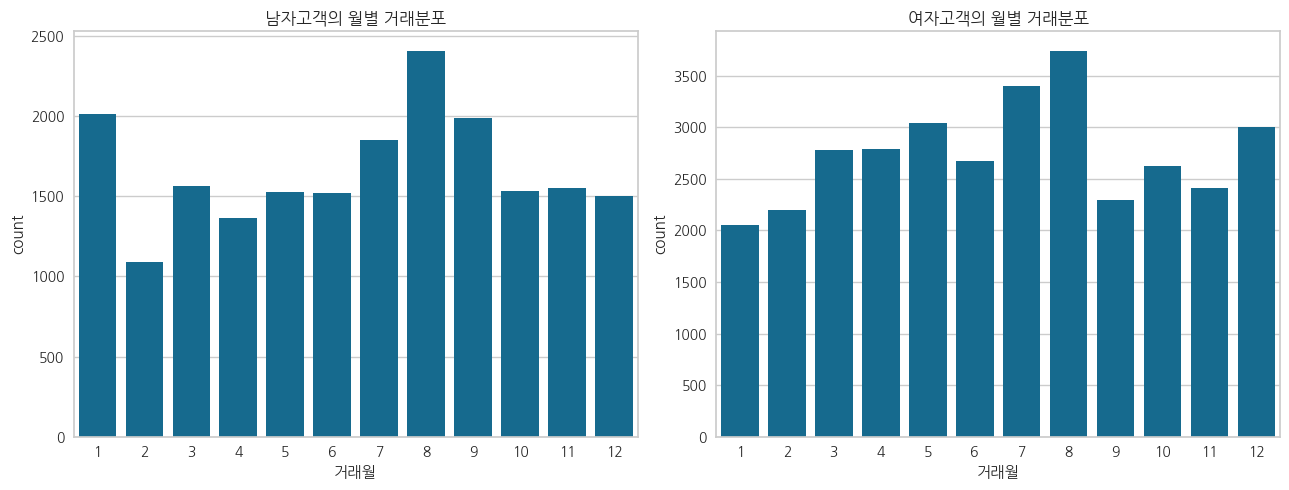

In [ ]:
plt.figure(figsize=(13,5))

plt.subplot(1,2,1)
plt.title("남자고객의 월별 거래분포")
sns.countplot(data=man, x="거래월", order=date_order)

plt.subplot(1,2,2)
plt.title("여자고객의 월별 거래분포")
sns.countplot(data=women, x="거래월", order=date_order)

plt.tight_layout()

In [ ]:
man["거래월"].value_counts(normalize=True).sort_index()*100 - women["거래월"].value_counts(normalize=True).sort_index()*100

1     3.896140
2    -1.190464
3    -0.583977
4    -1.608314
5    -1.542398
6    -0.482712
7    -0.983125
8     0.761236
9     3.029305
10   -0.249943
11    0.518038
12   -1.563786
Name: 거래월, dtype: float64

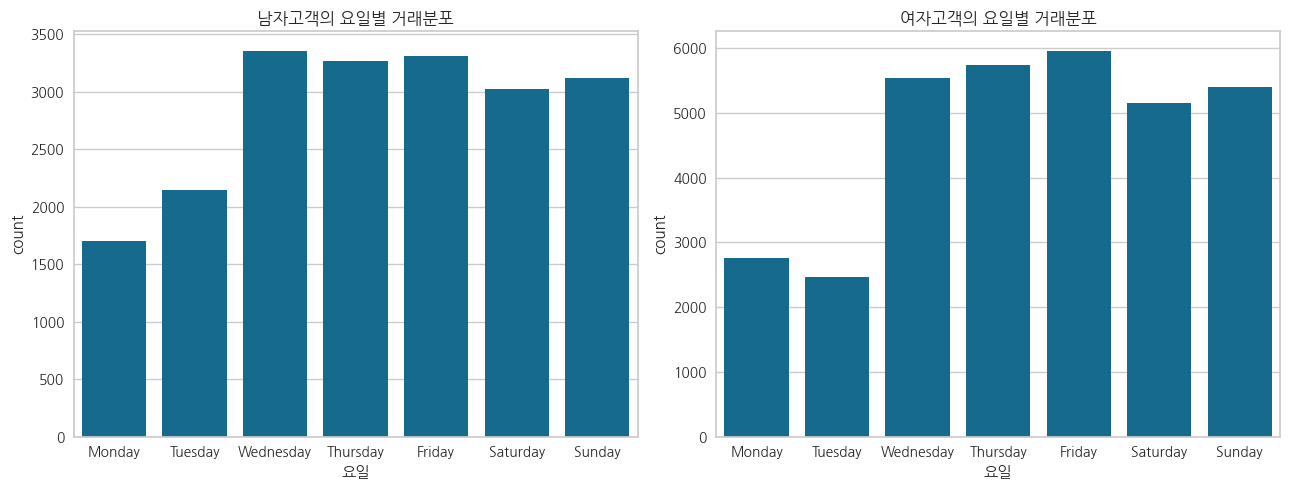

In [ ]:
plt.figure(figsize=(13,5))

plt.subplot(1,2,1)
plt.title("남자고객의 요일별 거래분포")
sns.countplot(data=man, x="요일", order=day_order)

plt.subplot(1,2,2)
plt.title("여자고객의 요일별 거래분포")
sns.countplot(data=women, x="요일", order=day_order)

plt.tight_layout()

요일차이는 별로안남..!

월 비교에서 둘다 높은 7,8월은 제외한 남자고객이 유독 높은 1월과 9월, 여자고객이 유독 높은 4월과 5월과 12월을 비교해보자

In [ ]:
popular_month_man = man[(man["거래월"] == 1) | (man["거래월"] == 9)].copy()
popular_month_women = women[(women["거래월"] == 4) | (women["거래월"] == 5) | (women["거래월"] == 12)].copy()

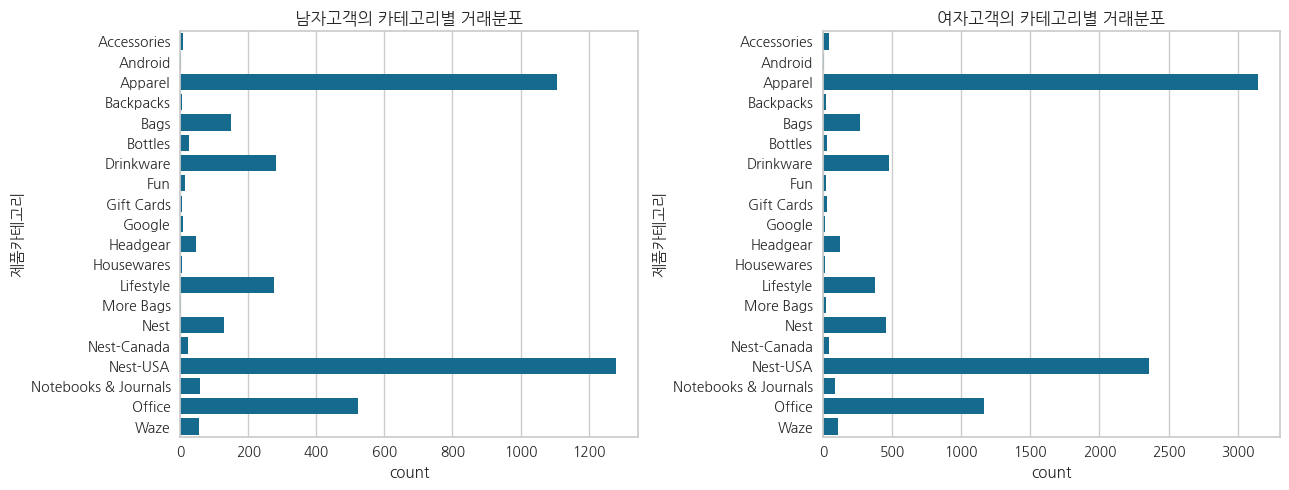

In [ ]:
plt.figure(figsize=(13,5))

plt.subplot(1,2,1)
plt.title("남자고객의 카테고리별 거래분포")
sns.countplot(data=popular_month_man, y="제품카테고리", order=category_order)

plt.subplot(1,2,2)
plt.title("여자고객의 카테고리별 거래분포")
sns.countplot(data=popular_month_women, y="제품카테고리", order=category_order)

plt.tight_layout()

카테고리는 별차이가 안보인다.. 선호하는 품목에 조금의 차이는 있지만 대체로 비슷하다.

In [ ]:
user_man = user_df[user_df["성별"] == "남"].copy()
user_women = user_df[user_df["성별"] == "여"].copy()

In [ ]:
user_df.columns

Index(['총거래금액', '구매횟수', '배송료', '고객지역', '성별', '제품ID', '제품카테고리', '할인금액', '고객등급',
       '거래금액대비_배송료'],
      dtype='object')

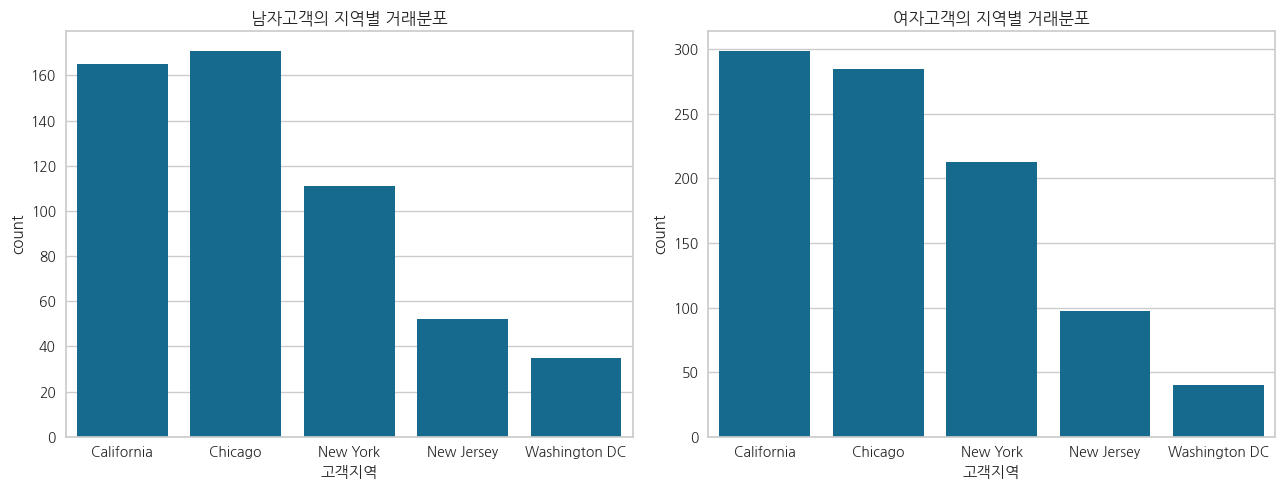

In [ ]:
plt.figure(figsize=(13,5))

plt.subplot(1,2,1)
plt.title("남자고객의 지역별 거래분포")
sns.countplot(data=user_man, x="고객지역", order=area_order)

plt.subplot(1,2,2)
plt.title("여자고객의 지역별 거래분포")
sns.countplot(data=user_women, x="고객지역", order=area_order)

plt.tight_layout()

지역 차이 없음.!!

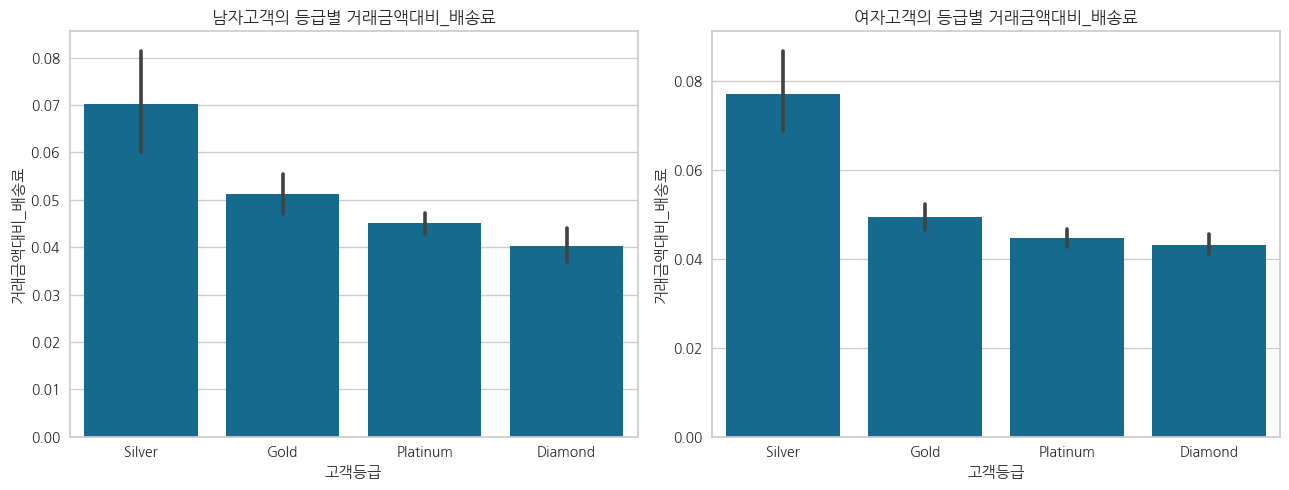

In [ ]:
plt.figure(figsize=(13,5))

plt.subplot(1,2,1)
plt.title("남자고객의 등급별 거래금액대비_배송료")
sns.barplot(data=user_man, x="고객등급", y="거래금액대비_배송료", order=grade_order)

plt.subplot(1,2,2)
plt.title("여자고객의 등급별 거래금액대비_배송료")
sns.barplot(data=user_women, x="고객등급", y="거래금액대비_배송료", order=grade_order)

plt.tight_layout()

거래금액대비_배송료 차이없음

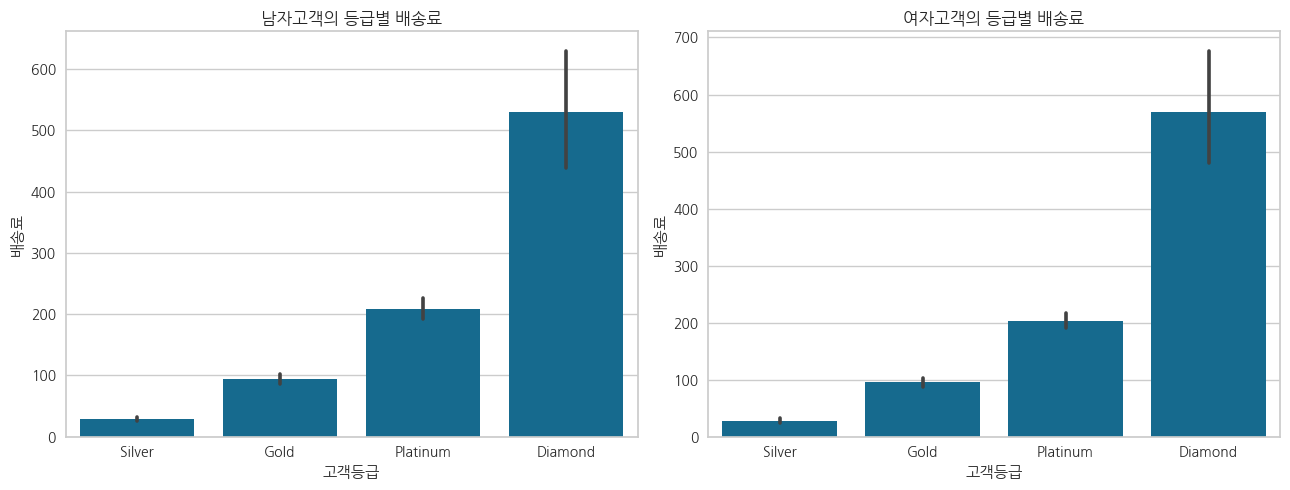

In [ ]:
plt.figure(figsize=(13,5))

plt.subplot(1,2,1)
plt.title("남자고객의 등급별 배송료")
sns.barplot(data=user_man, x="고객등급", y="배송료", order=grade_order)

plt.subplot(1,2,2)
plt.title("여자고객의 등급별 배송료")
sns.barplot(data=user_women, x="고객등급", y="배송료", order=grade_order)

plt.tight_layout()

배송료도 차이없음..!

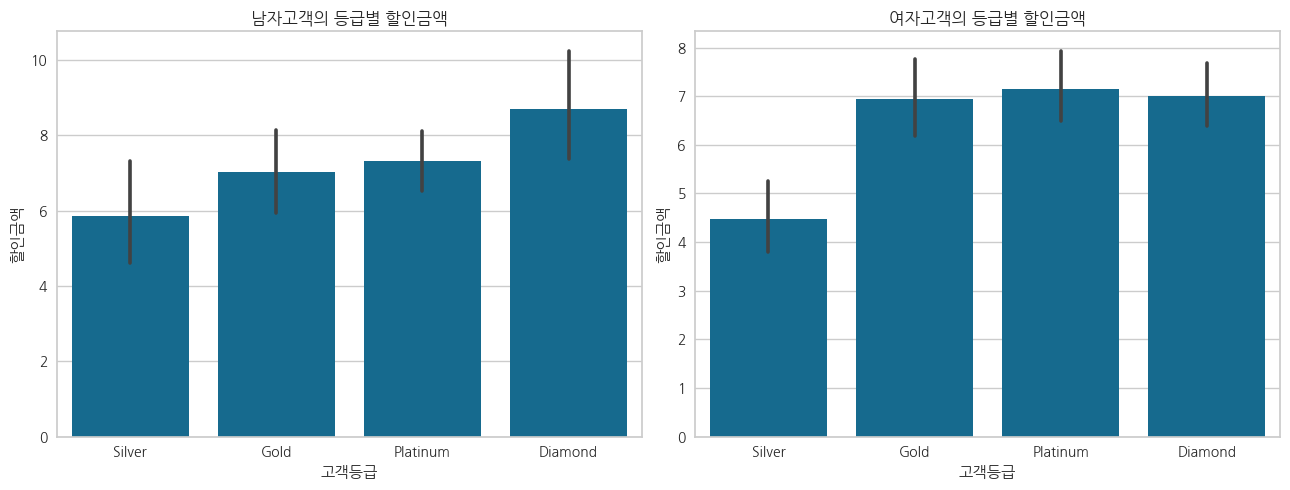

In [ ]:
plt.figure(figsize=(13,5))

plt.subplot(1,2,1)
plt.title("남자고객의 등급별 할인금액")
sns.barplot(data=user_man, x="고객등급", y="할인금액", order=grade_order)

plt.subplot(1,2,2)
plt.title("여자고객의 등급별 할인금액")
sns.barplot(data=user_women, x="고객등급", y="할인금액", order=grade_order)

plt.tight_layout()

미세한 차이가 있는데.. 이것만으로 뭘 보기는 어려워보임

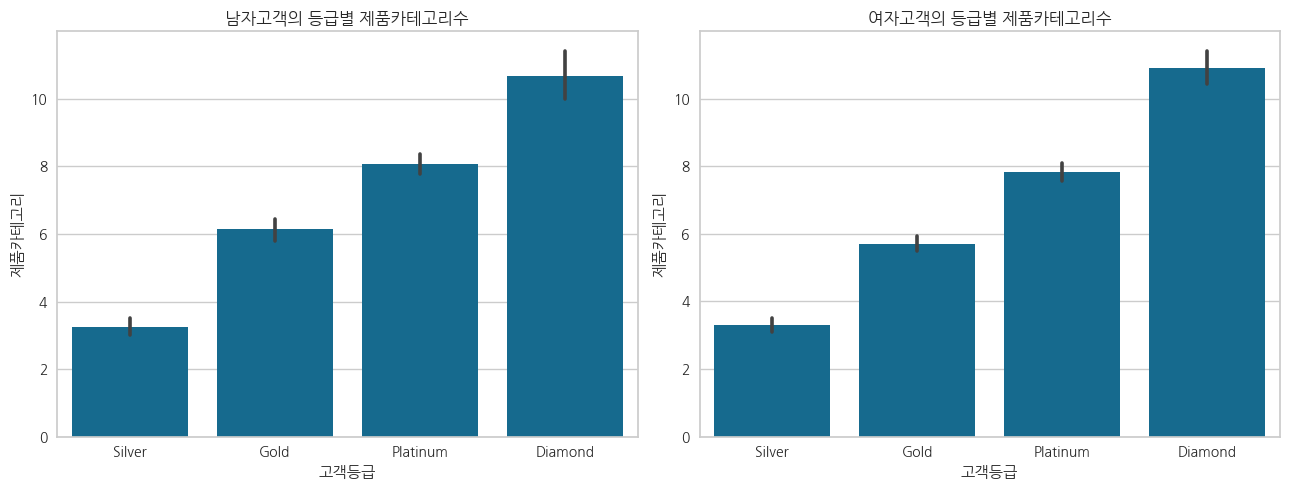

In [ ]:
plt.figure(figsize=(13,5))

plt.subplot(1,2,1)
plt.title("남자고객의 등급별 제품카테고리수")
sns.barplot(data=user_man, x="고객등급", y="제품카테고리", order=grade_order)

plt.subplot(1,2,2)
plt.title("여자고객의 등급별 제품카테고리수")
sns.barplot(data=user_women, x="고객등급", y="제품카테고리", order=grade_order)

plt.tight_layout()

음... 별차이없음

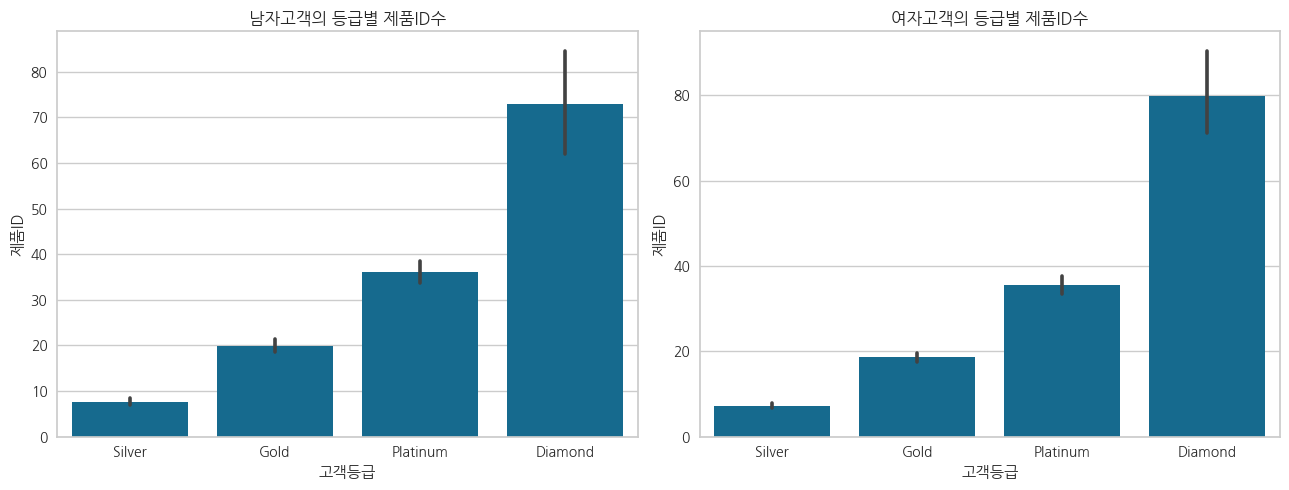

In [ ]:
plt.figure(figsize=(13,5))

plt.subplot(1,2,1)
plt.title("남자고객의 등급별 제품ID수")
sns.barplot(data=user_man, x="고객등급", y="제품ID", order=grade_order)

plt.subplot(1,2,2)
plt.title("여자고객의 등급별 제품ID수")
sns.barplot(data=user_women, x="고객등급", y="제품ID", order=grade_order)

plt.tight_layout()

에헴.. 별로없다